#CIS 545 Group Project
By Jeffrey Li, Shriya Karam, Sindhura Mente <br>
December 12, 2022

# Motivation

In this project, we leverage data analytics tools and machine learning algorithms to understand the San Francisco Bay Area Bike Share data provided by Kaggle [1]. Since its launch in 2013, the Bay Wheels Bike Share Program has provided affordable and accessible transportation across the San Francisco Bay Area. The regional bicycle sharing system partners with local government agencies and corporations like Lyft and currently has over 7000 traditional and electric bicycles at 550 stations [2].

In this project, we want to extract insights from the data and produce reliable models that can aid Bay Wheels in making decisions regarding bike share network expansion. The ultimate objective is to predict bike share trip durations for a given day, based on features such as weather conditions, station characteristics, and time. We focus on trip duration as an indicator of trip intensity (i.e. how long a trip is is a measure of how intensely the individual used bike share on their given trip). Being knowledgeable about the factors involved in predicting intensity of usage is important for ensuring Bay Wheels’ system is accessible to all and serves as a resilient mode of tansportation. Ultimately, by determining key factors of trip intensity, we seek to advise Bay Wheels on particular areas for system expansion and enhancement [3].

Through our exploration, we study internal and external factors that impact bike share trip durations and uncover trends across both location, time, and weather-related factors. To understand relationships between stations and key trip factors, we first use k-means clustering as an unsupervised learning method. We consider both regression and classification-based models given we have real inputs and want to predict trip durations as a continuous variable or as a categorical binary variable (i.e., short and long trips). We employ grid search cross-validation for hyperparameter tuning in order to improve our classification model and also present our final models.

# Imports/Setup

In [ ]:
# install packages
!pip install -q numpy pandas matplotlib folium
%pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import re
import os
from google.colab import drive
from kneed import KneeLocator

# plotting
from matplotlib import cm
import seaborn as sns
import matplotlib.pyplot as plt

# calendar data
import datetime as dt
import calendar

# geospatial mapping
import folium
import folium.plugins
import geopy

#sklearn

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures

#  classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading



In this section, we load in and initially assess the three .csv files we will be working with. The datasets and their respective descriptions are as follows:

*   **station.csv** - data about stations where users can pickup or return bikes
*   **trip.csv** - data about individual bike trips
*   **weather.csv** - data about the weather on a specific day for certain zip codes. <br>

There are potentially many trends and patterns we can uncover through these datasets. For example, customers may enjoy longer bike rides during warmer weather, or perhaps different stations may experience dfferent patterns in rental durations. This exploration will be important for achieveing a greater understanding of the data we are working with and ultimately aid in our modeling. Before we can conduct these steps, we load in, prepare, and pre-process our data before the exploratory data analysis.

## Station Data

The **station.csv** file contains data about stations where users can pickup or return bikes. Each entry represents an individual station with information such as station name and ID, geographic coordinates, and dock count.

The column names and their respective descriptions are as follows:


*   id - unique ID number given to each station (int64)
*   name - station name (string object)
*   lat - latitude, geo-coordinate (float64)
*   long - longitude, geo-coordinate (float64)
*   dock count - number of individual bikes the station can hold (int64)
*   city - city where station is located (string object)
*   installation_date - date (m/d/yyyy) in which station was installed (string object).

In [ ]:
# Sindhu's filepath
# station_df = pd.read_csv('/content/drive/MyDrive/First Year/First Semester/CIS_5450/CIS_5450_Final_Project/Work/station.csv')

# Jeff/Shriya filepath
station_df = pd.read_csv('/content/drive/MyDrive/CIS_5450_Final_Project/Work/station.csv')

station_df.head(5)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
# rename columns to avoid problems in merging on later steps
station_df = station_df.rename(columns={"id": "station_id"})

In [ ]:
# glimpse of the columns and their datatypes
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         70 non-null     int64  
 1   name               70 non-null     object 
 2   lat                70 non-null     float64
 3   long               70 non-null     float64
 4   dock_count         70 non-null     int64  
 5   city               70 non-null     object 
 6   installation_date  70 non-null     object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.0+ KB


## Weather Data

The **weather.csv** provides data about the weather on a specific day for certain zip codes in the San Francisco Bay area. Each entry represents an individual date with information on characteristics such as temperature, visibility, and cloud cover.

The column names and their respective descriptions are as follows:

*   date - date (m/d/yyyy) when measurements were recorded (string object)
*   max_temperature_f - highest temperature in Farenheit (float64)
*   mean_temperature_f - mean temperature in Farenheit (float64)
*   min_temperature_f - lowest temperature in Farenheit (float64)
*   max_dew_point_f - highest dew point temperature in Farenheit (float64)
*   mean_dew_point_f - mean dew point temperature in Farenheit (float64)
*   min_dew_point_f - lowest dew point temperature in Farenheit (float64)
*   max_humidity -  maximum relative humidity, ratio value (float64)
*   mean_humidity - mean relative humidity, ratio value (float64)
*   min_humidity - minimum relative humidity, ratio value (float64)
*   max_sea_level_pressure_inches - maximum sea level pressure in inches (float64)
*   mean_sea_level_pressure_inches - mean sea level pressure in inches (float64)
*   min_sea_level_pressure_inches - minimum sea level pressure in inches (float64)
*   max_visibility_miles - maximum visibility in miles (float64)
*   mean_visibility_miles - mean visibility in miles (float64)
*   min_visibility_miles - minimum visibility in miles (float64)
*   max_wind_Speed_mph - maximum wind speed in miles per hour (float64)
*   mean_wind_speed_mph - mean wind speed in miles per hour (float64)
*   max_gust_speed_mph - minimum wind speed in miles per hour (float64)
*   precipitation_inches - amount of precipitation in inches (string object)
*   cloud_cover - categorical data on coverage of clouds binned between 0 (minimum) and 8 (maximum) (float64)
*   events - recorded weather phenonmena (rain, fog, thunderstorm, etc.) (string object)
*   wind_dir_degrees - direction from where the wind is blowing in degrees (float64)
*   zip_code - zip code where measurements were recorded (int64).

---
Weather Terms Definitions: <br>
1.   Dew Point: the temperature that the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100% [4]   <br>
2.   Relative Humidity: ratio, expressed in percent, of the amount of atmospheric moisture present relative to the amount that would be present if the air were saturated [5] <br>
3.   Visibility: the measure of the horizontal opacity of the atmosphere at the point of observation and is expressed in terms of the horizontal distance at which a person should be able to see and identify [6]


In [ ]:
# Sindhu filepath
# weather_df = pd.read_csv('/content/drive/MyDrive/First Year/First Semester/CIS_5450/CIS_5450_Final_Project/Work/weather.csv')

# Jeff/Shriya filepath
weather_df = pd.read_csv('/content/drive/MyDrive/CIS_5450_Final_Project/Work/weather.csv')

#preview the data
weather_df.head(5)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [ ]:
# glimpse of the columns and their datatypes
# notice that precipitation_inches is object type
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            3665 non-null   object 
 1   max_temperature_f               3661 non-null   float64
 2   mean_temperature_f              3661 non-null   float64
 3   min_temperature_f               3661 non-null   float64
 4   max_dew_point_f                 3611 non-null   float64
 5   mean_dew_point_f                3611 non-null   float64
 6   min_dew_point_f                 3611 non-null   float64
 7   max_humidity                    3611 non-null   float64
 8   mean_humidity                   3611 non-null   float64
 9   min_humidity                    3611 non-null   float64
 10  max_sea_level_pressure_inches   3664 non-null   float64
 11  mean_sea_level_pressure_inches  3664 non-null   float64
 12  min_sea_level_pressure_inches   36

In [ ]:
#rename the max_wind_Speed_mph column to be consistent with the other columns
weather_df = weather_df.rename(columns={"max_wind_Speed_mph": "max_wind_speed_mph"})

In [ ]:
#check for null values
weather_df.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

## Trip Data

The **trip.csv** provides data about individual bike trips. Each entry represents an individual bike trip with information such as trip duration, start date, start station, and zip code of the customer's billing address.

The column names and their respective descriptions are as follows:

*   id - unique id number associated with each trip (int64)
*   duration- duration of trip in seconds (int64)
*   start_date - trip start date and time (m/d/yyyy hh:mm) (string object)
*   start_station_name - station where trip started (string object)
*   start_station_id - unique station id number (int64)
*   end_date - trip end date and time (m/d/yyyy hh:mm) (string object)
*   end_station_name - station where trip ended (string object)
*   end_station_id - unique station id number (int64)
*   bike_id - unique id number associated with each bike (int64)
*   subscription_type - binary categorical data split between subscription holder and regular customer (string object)
*   zip_code - zip code of customer's billing address (string object).


In [ ]:
# Sindhu's filepath
# trip_df = pd.read_csv('/content/drive/MyDrive/First Year/First Semester/CIS_5450/CIS_5450_Final_Project/Work/trip.csv')

# Jeff/Shriya filepath
trip_df = pd.read_csv('/content/drive/MyDrive/CIS_5450_Final_Project/Work/trip.csv')

trip_df.head(5)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [ ]:
#rename the columns to be more informative
trip_df = trip_df.rename(columns={"id": "trip_id", "zip_code": "billing_zip_code"})

In [ ]:
#summary of the data
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   trip_id             669959 non-null  int64 
 1   duration            669959 non-null  int64 
 2   start_date          669959 non-null  object
 3   start_station_name  669959 non-null  object
 4   start_station_id    669959 non-null  int64 
 5   end_date            669959 non-null  object
 6   end_station_name    669959 non-null  object
 7   end_station_id      669959 non-null  int64 
 8   bike_id             669959 non-null  int64 
 9   subscription_type   669959 non-null  object
 10  billing_zip_code    663340 non-null  object
dtypes: int64(5), object(6)
memory usage: 56.2+ MB


# Data Preparation

In this section, we want to join our data sets (**station_df**, **weather_df**, and **trip_df**) on several key variables to eventually be used in exploratory dat analysis. Ultimately, we want to create one comprehensive data set where each row represents a particular trip, uniquely identified by a trip ID. Each trip should also contain information about where the trip started (city and station level information), when the trip occurred, the duration of the trip, and the weather on that day.

## Combining trip_df & weather_df

First, we want to merge the trip_df and weather_df, potentially on *date* and *zip code*, in order to obtain one data set that contains weather information for each trip. From **weather_df**, we see it only contains weather information from five zip codes. Since we know the stations span across more than five zip codes, we do not have complete weather information for all trips in **trip_df**. We also recognize that the *zip_code* column in **trip_df** contains the customer's billing address, rather than the zip code of where the trip originated. Thus we can proceed by merging **trip_df** and **weather_df** on *date* only and making the following assumptions:  <br>

To address this issue, we make some assumptions:
*   The weather in San Francisco (zip code: 94107) is representative of weather in other cities in the Bay Area for a given day.
*   The weather remains constant throughout the day.
*   The *start_date* and *end_date* in **trip_df** are the same date. <br>

These assumptions allow us to merge the dataframes on columns pertaining to date (in this case, *start_date* in the trip_df and *date* in the weather_df). Moreover, we can use solely weather data containing zip code 94107 from **weather_df**, which reduces the risk of getting nulls after we complete the join. While we might lose some precision with exact matchings on location due to data limitations, this is a risk we must take.

In [ ]:
# convert the trip_df date column to datetime: extract time
trip_df['time'] = pd.to_datetime(trip_df['start_date'], format='%m/%d/%Y %H:%M').dt.time

In [ ]:
# convert the trip_df date column to datetime: extract date
trip_df['start_date'] = pd.to_datetime(trip_df['start_date'], format='%m/%d/%Y %H:%M').dt.date

In [ ]:
# convert the weather_df date column to datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%m/%d/%Y').dt.date

In [ ]:
#weather_df has 5 zip codes
weather_df['zip_code'].value_counts()

94107    733
94063    733
94301    733
94041    733
95113    733
Name: zip_code, dtype: int64

We choose the zip code 94107 (which pertains to an area in San Francisco) to represent the weather across the Bay Area.

In [ ]:
weather_df_94107 = weather_df[weather_df['zip_code'] == 94107]
weather_df_94107.shape[0]

733

We merge **trip_df** and **weather_df** on *start_date* and *date*.

In [ ]:
#merge
trips_weather_df = pd.merge(trip_df, weather_df_94107, how='left', left_on=['start_date'], right_on = ['date'])
trips_weather_df.head()

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,mean_visibility_miles,min_visibility_miles,max_wind_speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,4576,63,2013-08-29,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,4607,70,2013-08-29,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
2,4130,71,2013-08-29,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
3,4251,77,2013-08-29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
4,4299,83,2013-08-29,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107


In [ ]:
# Drop duplicate column
trips_weather_df = trips_weather_df.drop(['date'], axis = 1)

To sense check the results of our merge, we can observe that the number of entries for the **trip_df** dataframe and resulting **trips_weather_df** are the same.

In [ ]:
len(trip_df) == len(trips_weather_df)

True

## Combining trip_weather_df & station_df

We now want to combine the **trip_weather_df** and **station_df**, in order to obtain station level information for each trip. We perform the merge on *start_station_id* and *station_id*, which both represent the unique identifer number for a station. In performing this merge, we only look at the starting station to specify the station information.

In [ ]:
# join the trips_weather_df and station_df
tws_df = trips_weather_df.merge(station_df, how = 'left', left_on = 'start_station_id', right_on = 'station_id')
tws_df.head()

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,events,wind_dir_degrees,zip_code,station_id,name,lat,long,dock_count,city,installation_date
0,4576,63,2013-08-29,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,...,NaN,286.0,94107,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,8/23/2013
1,4607,70,2013-08-29,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,...,NaN,286.0,94107,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013
2,4130,71,2013-08-29,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,...,NaN,286.0,94107,27,Mountain View City Hall,37.389218,-122.081896,15,Mountain View,8/16/2013
3,4251,77,2013-08-29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,...,NaN,286.0,94107,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013
4,4299,83,2013-08-29,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,...,NaN,286.0,94107,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,8/23/2013


In [ ]:
# drop columns, rename columns

# remove duplicate columns
tws_df = tws_df.drop(['station_id', 'name'], axis = 1)

# rename columns: starting station latittude and longitude
tws_df = tws_df.rename(columns={"lat": "start_lat", "long": "start_long"})

In [ ]:
# merging again to extract information regarding end station latitude and longitude
end_station = station_df[['station_id', 'lat', 'long']]
tws_df = tws_df.merge(end_station, how = 'left', left_on = 'end_station_id', right_on = 'station_id')

In [ ]:
# drop columns, rename columns

# remove duplicate columns
tws_df = tws_df.drop(['station_id'], axis = 1)

# rename columns
tws_df = tws_df.rename(columns={"lat": "end_lat", "long": "end_long"})

To sense check the results of our merge, we can observe that the number of entries for the **trip_df** dataframe and resulting **trips_weather_df** are the same.

In [ ]:
len(trips_weather_df) == len(tws_df)

True

In [ ]:
# reposition columns for organization purposes
tws_df = tws_df[['trip_id', 'duration', 'start_date', 'time', 'start_station_name',
                 'start_station_id', 'start_lat', 'start_long', 'city', 'zip_code',
                 'end_date', 'end_station_name', 'end_station_id', 'end_lat', 'end_long',
                 'dock_count', 'installation_date', 'bike_id', 'subscription_type',
                 'billing_zip_code', 'max_temperature_f', 'mean_temperature_f',
                 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
                 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
                 'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
                 'min_sea_level_pressure_inches', 'max_visibility_miles', 'mean_visibility_miles',
                 'min_visibility_miles', 'max_wind_speed_mph', 'mean_wind_speed_mph',
                 'max_gust_speed_mph', 'precipitation_inches', 'cloud_cover',
                 'events', 'wind_dir_degrees']]

## Train-Test Split

We prepared the final dataframe that contains all of the data, corresponding to trip information, weather, and station level information for each trip. In this next section, we will clean and proceed further with **tws_df** (fully merged **trip_df**, **weather_df**, and **station_df**). The first step will be to split the dataframe into training data (to train our proposed models) and testing data (to test the performance and robustness of our models).

**Note**: We are splitting our data into test and train sets prior to any significant data cleaning or imputation. There are two main reasons. The first reason is to avoid data leakage, which is when information from outside the training dataset is used to create the model. The second reason is that in practice, we should only have access to the training data and we should assume the training data is representative of a larger population. The testing data should only be accessed when we are assessing our models.

Therefore, we perform an 80:20 train-test split on **tws_df** before performing preprocessing the training and testing data.

In [ ]:
# 80:20 ratio, outputs are pandas df not numpy array
train_df, test_df = train_test_split(tws_df, test_size=0.2, random_state = 123)

# Data Preprocessing


Following merging the datasets into one complete dataframe and splitting the resulting dataframe into training and testing datasets, we proceed with data preprocessing.

## Preprocessing Functions

In [ ]:
#check the nulls in the training data
train_df.isnull().sum()

trip_id                                0
duration                               0
start_date                             0
time                                   0
start_station_name                     0
start_station_id                       0
start_lat                              0
start_long                             0
city                                   0
zip_code                               0
end_date                               0
end_station_name                       0
end_station_id                         0
end_lat                                0
end_long                               0
dock_count                             0
installation_date                      0
bike_id                                0
subscription_type                      0
billing_zip_code                    5287
max_temperature_f                      0
mean_temperature_f                     0
min_temperature_f                      0
max_dew_point_f                        0
mean_dew_point_f

We first create some functions to allow us to preprocess our data. There are only three rows in *train* with null values: *billing_zip_code*, *max_gust_speed_mph*, and *events*, so we want to implement some pre-processing steps to address these null values.

The first set of functions imputes the weather data for both the training and testing set. For the training data, we calculate the mean value for the *max_gust_speed_mph* column and perform imputation using that value. We use the same mean value to perform imputation on the testing data *max_gust_speed_mph* column.


In [ ]:
'''
This function fills in the max_gust_speed_mph column
if it is null for the training data with its mean value
'''
# max_gust_speed_mph
def impute_weather_train(df, col):
    mean_value = df[col].mean()
    df[col] = df[col].fillna(value=mean_value)
    return df[col]

'''
This function fills in the max_gust_speed_mph column
for the testing data if it is null with the mean value from the training
dataframe for this column
'''
# max_gust_speed_mph
def impute_weather_test(df, col, mean_value):
    df[col] = df[col].fillna(value=mean_value)
    return df[col]

This function performs imputation and capitalizes the first character of every string for the *events* column. Missing data is considered "Normal" as other entries indicate the presence of weather phenomena.

In [ ]:
'''
This function fills in the events column if it is null
for the training data with "Normal" and capitalizes the
first letter of the event for consistent labeling
'''
def normal_events(df, col):
    # no precipitation/phenomena = normal weather
    df.loc[df.events.isnull(), col] = "Normal"
    # capitalize first letter for consistent labels
    df[col] = df[col].str.capitalize()
    return df[col]

The column *billing_zip_code* contains missing values and contains non-numerical data. To clean this column, we use `clean_zip_code()` to flag entries as 'invalid' containing null values, containing non-numeric values, and containing less than five digits. For zip codes with more than five digits, only the first five are kept.


The function `billing()` calls `clean_zip_code()` to remove flagged entries.

In [ ]:
'''
This function cleans the billing_zip_code column in the
dataframe by dropping non-numeric characters, marking
the zip code as 'invalid' if it is below 5 characters,
and dropping values after a dash if the first 5 characters
are numeric. If the zip code is otherwise not 5 numeric
characters, then mark the zip code as 'invalid'
'''
def clean_zip_code(zip_val):

    #if the zip code contains non-numeric characters, then flag
    if (zip_val.isnumeric() == False):
      cleaned_zip = 'invalid'

    #if the length is less than 5 symbols, then flag
    elif (len(zip_val) < 5):
      cleaned_zip = 'invalid'

    #if the length has 5 symbols and is all numeric, then keep
    elif ((len(zip_val) == 5) & (zip_val.isnumeric())):
      cleaned_zip = zip_val

    #if the length has 5 symbols and then a dash, drop the values after the dash
    elif ((zip_val.isnumeric() == True) & (zip_val[5] == '-')):
      cleaned_zip = zip_val[0:5]

    # null, then flag
    else:
      cleaned_zip = 'invalid'
    return cleaned_zip

'''
This function calls clean_zip_code() and checks which
rows have an 'invalid' zipcode and drops them.
'''
def billing(df, col):
    df = df.dropna(subset = [col])
    df[col] = df[col].apply(lambda x: clean_zip_code(x))
    df = df[df[col] != 'invalid']
    return df

We bin the *time* column into groups of four hours, starting at midnight (i.e., 0:00:00). We perform binning to make the data more interpretable for us and for the audience. Moreover, the *time* data contains too many unique values to model effectively.

The time has been binned as follows:
*   late_night - 0:00:00 to 3:59:59
*   early_morning - 4:00:00 to 7:59:59
*   morning - 8:00:00 to 11:59:59
*   afternoon - 12:00:00 to 15:59:59
*   evening - 16:00:00 to 19:59:59
*   night - 20:00:00 to 23:59:59.


In [ ]:
'''
This function bins the time in groups (time of day) based on four hour increments.
The groups are: late_night, 'early_morning', 'morning', 'afternoon', 'evening',
and 'night.'
'''

def binning_time(time):
  if ((time >= dt.time(0, 0, 0)) & (time < dt.time(4, 0, 0))):
    return 'late_night'
  elif ((time >= dt.time(4, 0, 0)) & (time < dt.time(8, 0, 0))):
    return 'early_morning'
  elif ((time >= dt.time(8, 0, 0)) & (time < dt.time(12, 0, 0))):
    return 'morning'
  elif ((time >= dt.time(12, 0, 0)) & (time < dt.time(16, 0, 0))):
    return 'afternoon'
  elif ((time >= dt.time(16, 0, 0)) & (time < dt.time(20, 0, 0))):
    return 'evening'
  else:
    return 'night'

## Preprocessing Data

**Note:** Recall that we already conducted the train-test split. Thus, the training and testing data will be preprocessed separately based on the preprocessing functions defined above.

In [ ]:
#impute the weather data for max_gust_speed_mph
train_df['max_gust_speed_mph'] = impute_weather_train(train_df, 'max_gust_speed_mph')
test_df['max_gust_speed_mph'] = impute_weather_test(test_df, 'max_gust_speed_mph', train_df['max_gust_speed_mph'].mean())

In [ ]:
#clean events column
train_df['events'] = normal_events(train_df, 'events')
test_df['events'] = normal_events(test_df, 'events')

In [ ]:
#clean billing zip code column
train_df = billing(train_df, 'billing_zip_code')
test_df = billing(test_df, 'billing_zip_code')

<ipython-input-33-d51f3600528a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: clean_zip_code(x))


In [ ]:
#convert trip duration into minutes
train_df['duration'] = train_df['duration']/60
test_df['duration'] = test_df['duration']/60

We extract more information about month and day of the week from the *start_date* and store them into new columns, named accordingly.

In [ ]:
# add a month column in the train and test data sets
train_df['month'] = train_df['start_date'].apply(lambda x: calendar.month_name[x.month])
test_df['month'] = test_df['start_date'].apply(lambda x: calendar.month_name[x.month])

In [ ]:
#create a day of week column in the train and test data sets
train_df['day_of_week'] = train_df['start_date'].apply(lambda x: calendar.day_name[x.weekday()])
test_df['day_of_week'] = test_df['start_date'].apply(lambda x: calendar.day_name[x.weekday()])

We extract the time of day feature from the *time* and store then into new columns.

In [ ]:
#create time of day column in the train and test data sets
train_df['time_of_day'] = train_df['time'].apply(lambda x: binning_time(x))
test_df['time_of_day'] = test_df['time'].apply(lambda x: binning_time(x))

We have successfully cleaned up all the null values in our data set:

In [ ]:
train_df.isnull().sum()

trip_id                           0
duration                          0
start_date                        0
time                              0
start_station_name                0
start_station_id                  0
start_lat                         0
start_long                        0
city                              0
zip_code                          0
end_date                          0
end_station_name                  0
end_station_id                    0
end_lat                           0
end_long                          0
dock_count                        0
installation_date                 0
bike_id                           0
subscription_type                 0
billing_zip_code                  0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity               

## Cleaning Trip Duration

We look at the *duration* column and address potential outliers in our training data. As *duration* is our target, it is important that this variable is correctly format and well-cleaned.

In [ ]:
#summary statistics on the duration column
train_df['duration'].describe()

count    512207.000000
mean         15.652130
std         113.016433
min           1.000000
25%           5.650000
50%           8.433333
75%          12.166667
max       35616.666667
Name: duration, dtype: float64

Text(0.5, 1.0, 'Distribution of trip duration')

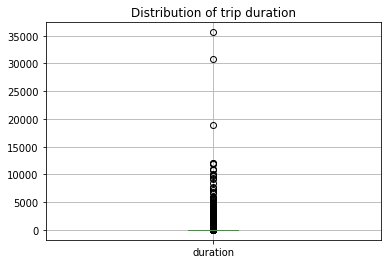

In [ ]:
# boxplot of trip duration
train_df.boxplot(['duration'])
plt.title("Distribution of trip duration")

From the descriptive statistics of *duration*, we notice potential outlier data. For example, one entry had a rental duration of 287840 minutes, which is about 200 days. We safely remove entries with outlier data, since they they are not representative of the population and may influence the performance of our models. Additionally, given the size of the overall dataset, our training data will not be negatively affected after dropping them.

We perform percentile capping to remove these outliers, in which any data points less than the value at first percentile or greater than value at 99th percentile are considered outliers. [7]

In [ ]:
# Removing outliers following the method above
q_low = train_df['duration'].quantile(0.01)
q_high  = train_df['duration'].quantile(0.99)

train_df = train_df[(train_df['duration'] < q_high) & (train_df['duration'] > q_low)]

In [ ]:
# outliers have been removed
train_df['duration'].describe()

count    501932.000000
mean         10.924831
std          12.313955
min           2.116667
25%           5.700000
50%           8.433333
75%          12.066667
max         154.900000
Name: duration, dtype: float64

Text(0.5, 1.0, 'Distribution of trip duration')

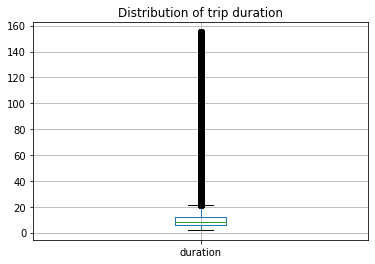

In [ ]:
# boxplot of trip duration
train_df.boxplot(['duration'])
plt.title("Distribution of trip duration")

**Note:** We do not drop testing data outliers, since we want to assess the robustness of our model.

# Exploratory Data Analysis (EDA)

With our data preprocessed, we explore our data to understand and uncover trends and patterns. We only perform exploratory data analysis (EDA) on the **training data**, since in practice we do not have access to testing data (until model assessment).

We want to base our EDA on our guiding question: **How can we predict the duration of a bike share rental?** <br>

Potential questions to explore:
*   How long are trips on average?
*   What does the **distribution** of trip durations look like?
*   How does the **distribution** of trip durations vary for different cities, days, months, etc.?
*   How does weather impact bike trip durations?
*   How do bike trip patterns vary by time of day and the day of the week?
*   Which month/day has the most number of trips?
*   How do bike trip patterns differ from neighborhood/city?
*   What stations are more popular?
*   Does subscription type of the customer impact bike share trip duration?

### Distribution of Trip Duration

Text(0.5, 1.0, 'Distribution of Bike Share Trip Durations')

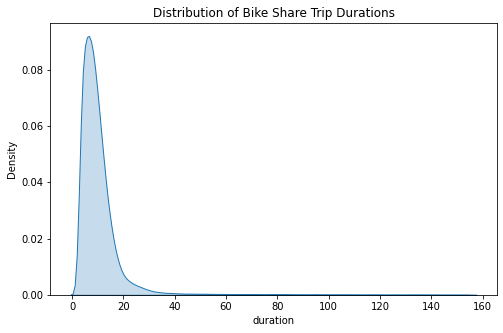

In [ ]:
#density plot of all bike share trip durations
plt.figure(figsize=(8,5))
sns.kdeplot(train_df['duration'], shade=True)
plt.title("Distribution of Bike Share Trip Durations")

Based on this density plot, we observe that the a large percentage of bike share trips are less than 20 minutes, with almost all of them being less than an hour. We observe the highest peak at around 10 minutes, with a long right tail that indicates a few extreme points.

### Trip Duration Over Time

Text(0.5, 1.0, 'Average Duration of Bike Share Trips By Day')

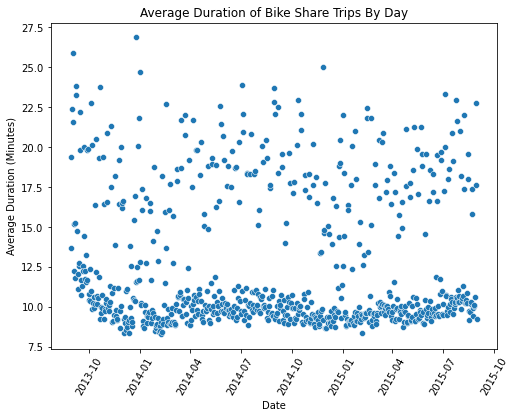

In [ ]:
#for each start date, compute the average trip duration
dur_date = train_df.groupby('start_date')['duration'].mean().reset_index()

#scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x = 'start_date', y = 'duration', data = dur_date)
plt.xlabel("Date")
plt.xticks(rotation=60)
plt.ylabel("Average Duration (Minutes)")
plt.title("Average Duration of Bike Share Trips By Day")

The figure above shows trip start date on the x-axis and average trip duration by date on the y-axis. Overall, we see some seasonality trends (longer trip durations in the summer months). Generally, the averages by date are clustered between 8 minutes and 12 minutes.

## Cities & Trip Duration

In [ ]:
#group by city and calculate average duration
dur_city = train_df.groupby('city')['duration'].mean().reset_index()
dur_city

,city,duration
0,Mountain View,9.392884
1,Palo Alto,23.966324
2,Redwood City,12.314700
3,San Francisco,10.837721
4,San Jose,10.816069


Text(0.5, 1.0, 'Average Bike Share Trip Duration by City')

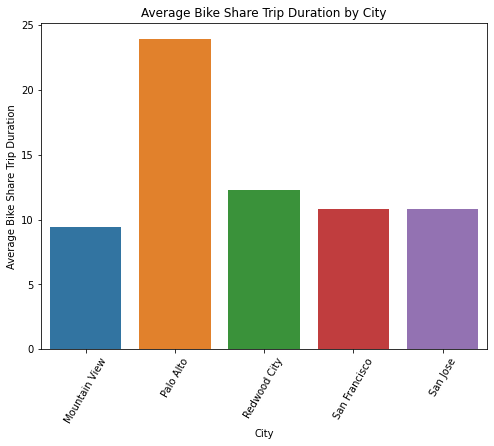

In [ ]:
#barplot of average trip duration by city
plt.figure(figsize=(8,6))
sns.barplot(x = "city", y = "duration", data = dur_city, dodge = True)
plt.xticks(rotation=60)
plt.xlabel("City")
plt.ylabel("Average Bike Share Trip Duration")
plt.title("Average Bike Share Trip Duration by City")

The five cities featured in this data set are Mountain View, Palo Alto, Redwood City, San Francisco, and San Jose. We see that on average, Palo Alto has the longest average trip duration at around 24 minutes. On average, bike share trip durations for Palo Alto are generally longer compared to trip durations for other cities.

Text(0.5, 1.0, 'Distribution of bike share trip duration by city')

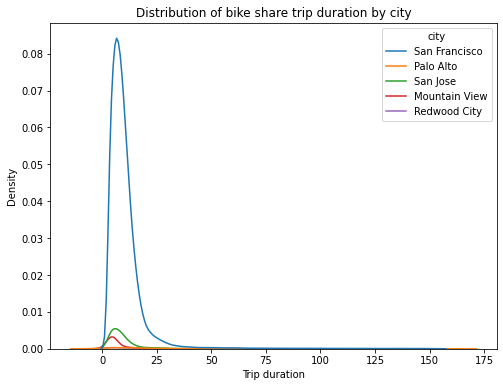

In [ ]:
#density plot of trip duration by city
plt.figure(figsize=(8,6))
sns.kdeplot(data=train_df, x="duration", hue="city")
plt.xlabel("Trip duration")
plt.ylabel("Density")
plt.title("Distribution of bike share trip duration by city")

In the figure above, we plot the distributions for trip duration for the five cities in our data set. Out of all the cities, Redwood City appears to have the greatest density at around a 10 minute bike share trip duration. The distributions for the other cities appear to be more spread out. In the previous figure, Palo Alto has the highest average trip duration, which concurs with its density plot as its trip duration distribution is more spread out.

##Weather & Trip Duration


In this section, we explore the relationship between the weather features and bike share trip durations. By computing the correlation matrix, we observe that there is low correlation between the numeric weather features and trip duration, so we probably do not want to include them in our regression models. However, we recognize that we may have more to work with if instead of the numeric variables, we use the *events* column to categorize the data.

In [ ]:
#create a correlation matrix between trip duration and the numeric columns
correlations = train_df[['duration', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'wind_dir_degrees']].corr()

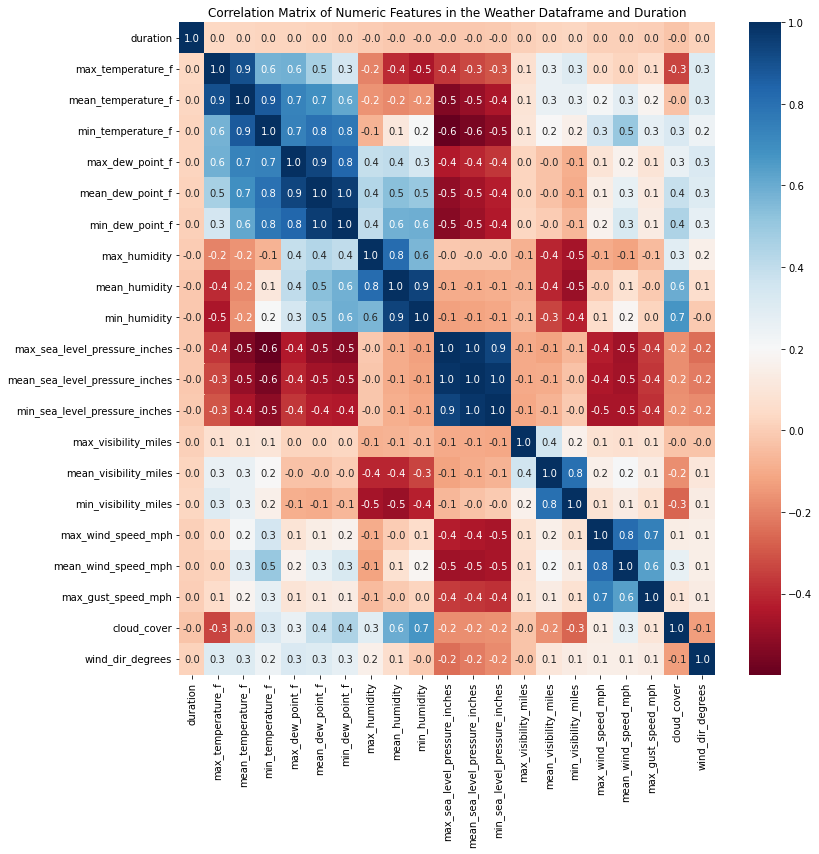

In [ ]:
#plot the correlation matrix as a heat map
plt.figure(figsize=(12, 12))
plt.title('Correlation Matrix of Numeric Features in the Weather Dataframe and Duration')
sns.heatmap(correlations, cmap="RdBu", annot=True, fmt=".1f")

In [ ]:
#look at correlations with trip duration
correlations['duration']

duration                          1.000000
max_temperature_f                 0.032540
mean_temperature_f                0.030905
min_temperature_f                 0.021239
max_dew_point_f                   0.019690
mean_dew_point_f                  0.015385
min_dew_point_f                   0.011130
max_humidity                     -0.003836
mean_humidity                    -0.013734
min_humidity                     -0.017268
max_sea_level_pressure_inches    -0.015739
mean_sea_level_pressure_inches   -0.012662
min_sea_level_pressure_inches    -0.011204
max_visibility_miles              0.009751
mean_visibility_miles             0.020877
min_visibility_miles              0.027713
max_wind_speed_mph                0.011485
mean_wind_speed_mph               0.011858
max_gust_speed_mph                0.003740
cloud_cover                      -0.028885
wind_dir_degrees                  0.017968
Name: duration, dtype: float64

We see low correlations between the numerical weather features and the trip duration from observing the row and column in the heatmap for the duration feature. Let's look at the events column to see if there could be any correlation between the weather events column and trip duration.

In [ ]:
#group by events and calculate the average trip duration
events_duration = train_df.groupby('events')['duration'].mean().reset_index()
events_duration

,events,duration
0,Fog,11.102587
1,Fog-rain,9.911292
2,Normal,11.052016
3,Rain,9.972228
4,Rain-thunderstorm,12.033389


Text(0.5, 1.0, 'Distribution of bike share trip duration by weather event')

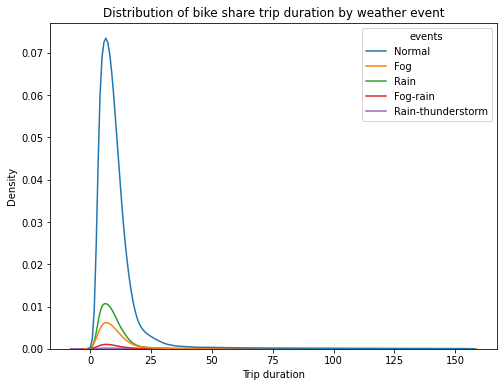

In [ ]:
#density plot of trip duration by weather event
plt.figure(figsize=(8,6))
sns.kdeplot(data=train_df, x="duration", hue="events")
plt.xlabel("Trip duration")
plt.ylabel("Density")
plt.title("Distribution of bike share trip duration by weather event")

Here we see that the distributions of the different weather events are similar, but with different densities. Out of all the weather events, normal weather appears to have the greatest density at around a 10 minute duration of the bike share trip, while the distributions for the other events appear more flattened out.

Next we explore the relationships among weather, city, and trip duration.

Text(0.5, 1.0, 'Average trip duration by weather event and city')

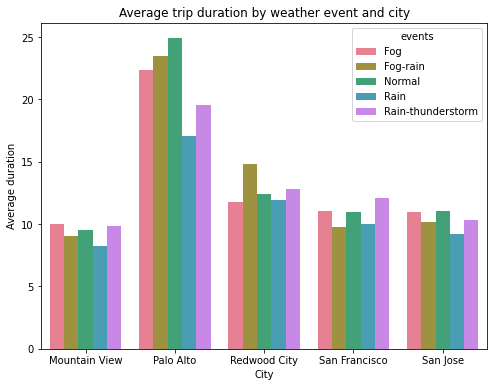

In [ ]:
#group by city and event calculate mean trip duration
grouped_df = train_df.groupby(['city', 'events'])['duration'].mean().reset_index()

#barplot
plt.figure(figsize=(8,6))
sns.barplot(x="city", y='duration', hue='events', data=grouped_df, dodge=True, palette='husl')
plt.xlabel("City")
plt.ylabel("Average duration")
plt.title("Average trip duration by weather event and city")

In the figure above, we observe the average trip duration by weather event for all five cities in our data set. We observe that Palo Alto has the highest overall average trip duration as well as the most variation in average trip duration across weather events. Other cities -- Mountain View, San Francisco, and San Jose -- shows less variation in average trip duration across events.

## Subscription Type & Duration

In [ ]:
# avg duration by subscription type
subscriber_duration = train_df.groupby('subscription_type')['duration'].mean().reset_index()
subscriber_duration

,subscription_type,duration
0,Customer,26.980801
1,Subscriber,8.938871


Text(0, 0.5, '')

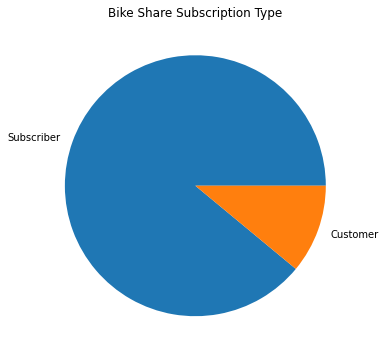

In [ ]:
# pie chart of subscription type
plt.figure(figsize=(8,6))
train_df['subscription_type'].value_counts().plot.pie()
plt.title("Bike Share Subscription Type")
plt.ylabel("")

Text(0.5, 1.0, 'Average bike share trip duration by subscription type')

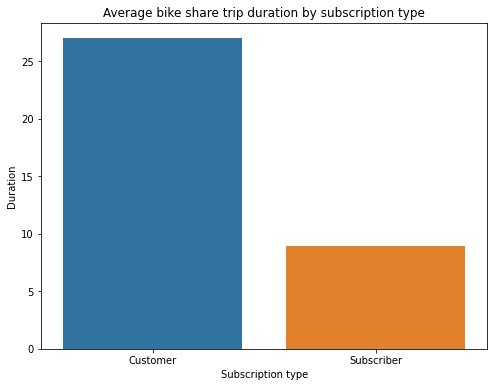

In [ ]:
#barplot of average trip duration by subscriber
plt.figure(figsize=(8,6))
sns.barplot(x = "subscription_type", y = "duration", data = subscriber_duration, dodge = True)
plt.xlabel("Subscription type")
plt.ylabel("Duration")
plt.title("Average bike share trip duration by subscription type")

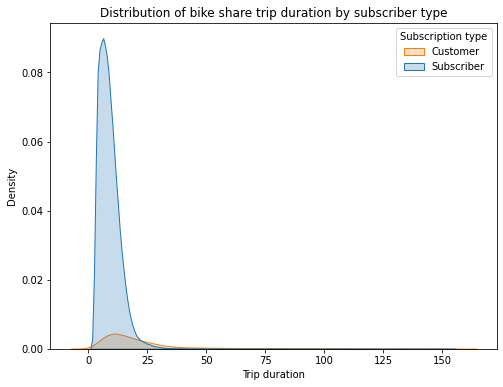

In [ ]:
#density plot of bike share trip duration by subscription type
plt.figure(figsize=(8,6))
sns.kdeplot(data=train_df, x="duration", hue="subscription_type", shade=True)
plt.xlabel("Trip duration")
plt.ylabel("Density")
plt.title("Distribution of bike share trip duration by subscriber type")
plt.legend(title="Subscription type", labels=['Customer', 'Subscriber'])

From looking at the bar plot and density plots, it appears that there are large differences between the average duration of a trip between subscribers and customers. For customers, average trip duration is around 20 minutes, while for subscribers, the average trip duration is around 10 minutes. In observing the density plots, we see that the customers' distribution is more spread out.  This indicates that trips taken by subscribers were taken at low intensity (shorter duration), while customers took much more intense trips (longer duration), which may indicate more leisure trips. Furthermore, subscribers make a greater proportion of the people who use bike share compared to customers, as shown in the pie chart.

Next we explore the relationship among subscriber type, city, and duration.

Text(0.5, 1.0, 'Average trip duration by subscription type and city')

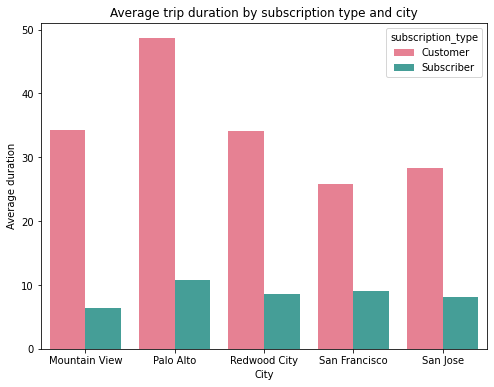

In [ ]:
#group by city and subscription type and calculate average trip duration
grouped_df = train_df.groupby(['city', 'subscription_type'])['duration'].mean().reset_index()

#barplot
plt.figure(figsize=(8,6))
sns.barplot(x="city", y='duration', hue='subscription_type', data=grouped_df, dodge=True, palette='husl')
plt.xlabel("City")
plt.ylabel("Average duration")
plt.title("Average trip duration by subscription type and city")

In the figure above, we observe that across all cities, there were on average, longer trips taken by customers rather than subscribers. This trend holds for all cities while Palo Alto has the highest overall average trip duration.

## Stations & Trip Duration

In [ ]:
# group by start station and calcualte the average trip duration
station_duration = train_df.groupby('start_station_name')['duration'].mean().sort_values(ascending=False).reset_index()

#look at top 5 stations
station_duration_top5 = station_duration.head(5)
station_duration_top5

,start_station_name,duration
0,University and Emerson,45.948259
1,California Ave Caltrain Station,23.371377
2,Park at Olive,21.191806
3,San Jose Civic Center,20.917916
4,Palo Alto Caltrain Station,18.338142


Text(0.5, 1.0, 'Average bike share trip duration for the top 5 start stations')

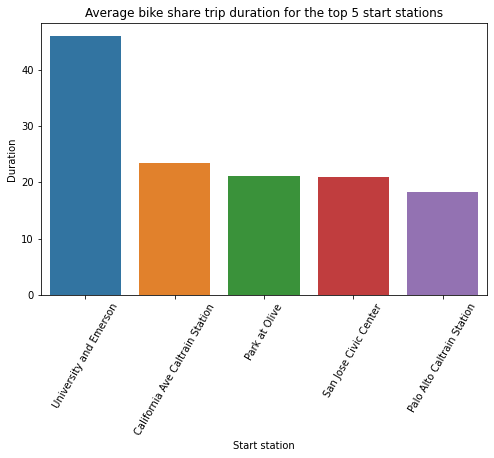

In [ ]:
#plot top 5 stations with the longest average trip durations
plt.figure(figsize=(8,5))
sns.barplot(x = "start_station_name", y = "duration", data = station_duration_top5, dodge = True)
plt.xlabel("Start station")
plt.ylabel("Duration")
plt.xticks(rotation=60)
plt.title("Average bike share trip duration for the top 5 start stations")

The figure above shows the start station on the x-axis and the average trip duration on the y-axis. From the figure, we see that the University and Emerson station had the largest average trip duration of all the stations.

We explore the relationship among station, city, and trip duration.

<Figure size 1080x576 with 0 Axes>

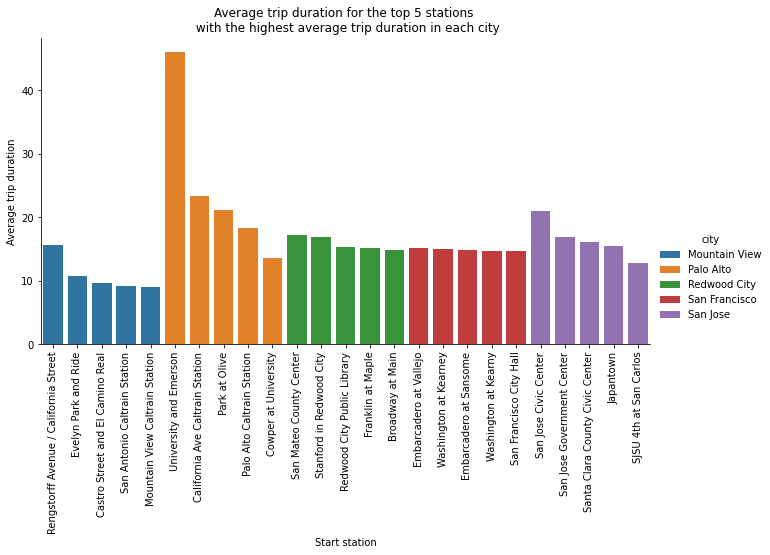

In [ ]:
#group by cities and stations and calculate average duration
cities_stations = train_df.groupby(['city', 'start_station_name'])['duration'].mean().reset_index()
cities_stations.rename(columns={'duration': 'avg_duration'}, inplace=True)

#look at top 5 stations per each city based on average trip duration
cities_stations = cities_stations.sort_values(by='avg_duration', ascending=False).groupby('city').head(5)
cities_stations_top_5 = cities_stations.sort_values(['city', 'avg_duration'], ascending = [True, False])

#bar plot of average trip duration for the top 5 stations with the highest trip duration per city
plt.figure(figsize=(15,8))
ax = sns.catplot(data=cities_stations_top_5, x="start_station_name", y="avg_duration", hue="city", kind="bar", height = 5, aspect = 2, dodge=False)
plt.xticks(rotation=90)
ax.set(ylabel='Average trip duration')
ax.set(xlabel='Start station')
ax.set(title='Average trip duration for the top 5 stations \n with the highest average trip duration in each city')

The figure above plots average trip duration for the top 5 stations with the highest trip duration per city. Start station is on the x-axis, average trip duration is on the y-axis, and the bar plots are colored based on the city. Similar to the previous plots, Palo Alto generally features the longest average bike share trip duration, with the University and Emerson station being the station with the highest average trip duration.

## Trip Duration Across Months & Weeks

Text(0.5, 1.0, 'Distributions of trip durations by month')

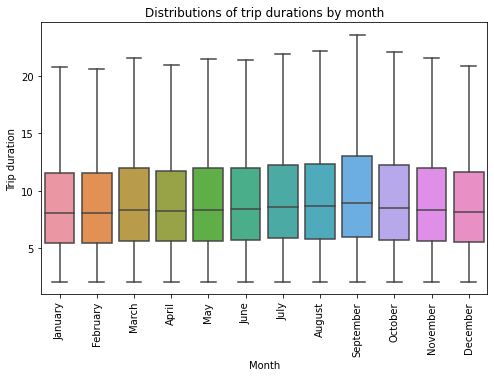

In [ ]:
#bike share trip duration by month
#reorder the months for better visualization
trip_station_df_month = train_df[["month", "duration"]].sort_values(by = "month")

ordered_months = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

trip_station_df_month['month'] = pd.Categorical(trip_station_df_month['month'], categories = ordered_months, ordered=True)

#boxplot for each month
plt.figure(figsize=(8,5))
sns.boxplot(x = "month", y = "duration", data = trip_station_df_month, showfliers = False)
plt.xlabel("Month")
plt.ylabel("Trip duration")
plt.xticks(rotation=90)
plt.title("Distributions of trip durations by month")

In the figure above, we have month on the x-axis and trip duration on the y-axis, where for each month, we have a boxplot representing the distribution of trip durations during that month. Overall, we see little variation and relatively similar distributions in trip duration across the months.

Text(0.5, 1.0, 'Distributions of trip durations by day of the week')

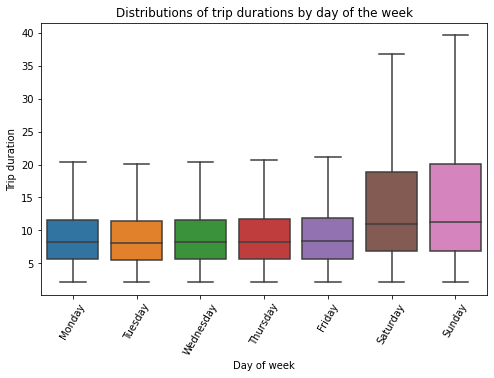

In [ ]:
#bike share trip duration by week
#reorder the days of the week for better visualization
trip_station_df_week = train_df[["day_of_week", "duration"]].sort_values(by = "day_of_week")

ordered_days = ['Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

trip_station_df_week['day_of_week'] = pd.Categorical(trip_station_df_week['day_of_week'], categories = ordered_days, ordered=True)

#boxplot for each day of the week
plt.figure(figsize=(8,5))
sns.boxplot(x = "day_of_week", y = "duration", data = trip_station_df_week, showfliers = False)
plt.xlabel("Day of week")
plt.ylabel("Trip duration")
plt.xticks(rotation=60)
plt.title("Distributions of trip durations by day of the week")

We see that the trips vary more on the weekend as opposed to other days, and that they have larger average durations on average. We thus create the binary variable *weekday_or_weekend* which indicates whether a trip ocurred on a weekday or on a weekend.

### Creating Binary Feature for Weekday/Weekend

In [ ]:
#create weekend/weekday binary variable
train_df['weekday_or_weekend'] = train_df['day_of_week'].apply(lambda x: "weekend" if (x == 'Saturday') | (x == 'Sunday') else 'weekday')

test_df['weekday_or_weekend'] = test_df['day_of_week'].apply(lambda x: "weekend" if (x == 'Saturday') | (x == 'Sunday') else 'weekday')

Text(0.5, 1.0, 'Distributions of trip durations by weekend and weekday')

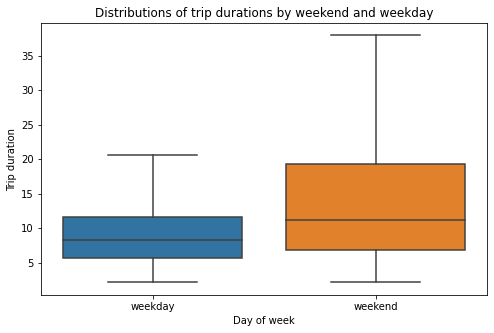

In [ ]:
#create dataframe trip_station_df_weekend
trip_station_df_weekend = train_df[["weekday_or_weekend", "duration"]].sort_values(by = "weekday_or_weekend")

#boxplot for weekday vs weekend
plt.figure(figsize=(8,5))
sns.boxplot(x = "weekday_or_weekend", y = "duration", data = trip_station_df_weekend, showfliers = False)
plt.xlabel("Day of week")
plt.ylabel("Trip duration")
plt.title("Distributions of trip durations by weekend and weekday")

The boxplot above could indicate that bike trips on weekends are leisure trips rather than commuting trips (work, errands, etc.) based on the average trip duration. We assume leisure trips to be longer compared to computing trips.

## Time of Day & Trip Duration

Text(0.5, 1.0, 'Average trip duration by time of day and city')

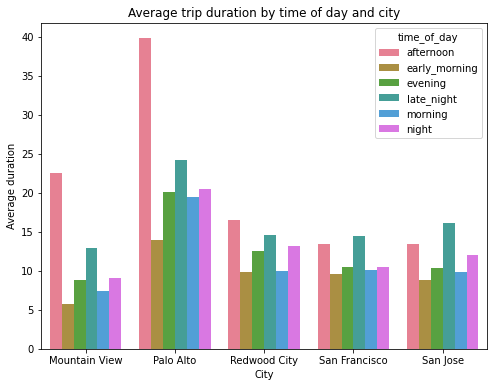

In [ ]:
#group by city and time of day and calculate mean trip duration
grouped_df = train_df.groupby(['city', 'time_of_day'])['duration'].mean().reset_index()

#barplot
plt.figure(figsize=(8,6))
sns.barplot(x="city", y='duration', hue='time_of_day', data=grouped_df, dodge=True, palette='husl')
plt.xlabel("City")
plt.ylabel("Average duration")
plt.title("Average trip duration by time of day and city")

In the figure above, we observe the average trip duration by time of day for all five cities in our data set. We observe that the afternoon period generally shows longer trip durations, while the late night and evening periods also show longer trip durations. The early morning period shows shorter trip durations on average when compared to the other time periods, most likely to do with the odd hours.

## Station Analysis

We hypothesize that station characteristics and locations would have an effect on trip durations. In this section, we explore the geospation distribution of stations as well as produce a k-means clustering model to determine any similarities across stations that would be useful in our later models.

### Geospatial Distribution of Stations

In [ ]:
# plot the stations geographically
# https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94
station_copy = station_df.loc[:, ['lat', 'long']].copy()
map = folium.Map(width=500,height=500, location=[station_copy.lat.mean(), station_copy.long.mean()], control_scale=True)
for index, location_info in station_copy.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]]).add_to(map)
map

From visualizing the map, we see the stations form geospatial clusters at San Jose, San Francisco, Mountain View, Palo Alto, and Redwood City, which are the cities that this data set features. San Francisco has the greatest number of stations.

In [ ]:
#heat map representing dock count density at each station
station_hm = station_df.loc[:, ['lat', 'long']].copy()

#normalize the dock count
station_hm.loc[:, 'dock_count_norm'] = (station_df.dock_count - station_df.dock_count.min()) / (station_df.dock_count.max() - station_df.dock_count.min())

heat_map = folium.Map(width=500,height=500, location=[station_hm.lat.mean(), station_hm.long.mean()], zoom_start=10)
folium.plugins.HeatMap(station_hm.values.tolist()).add_to(heat_map)

heat_map

Based on this heat map, we see that San Francisco has the greatest magnitude of dock counts across all stations compared to other cities. From earlier sections, we saw that Palo Alto had the highest average bike share trip duration compared to the other cities. Thus, this indicates greater intensity despite the lower number of dock counts (and bikes).

### Number of Stations in Each City

In [ ]:
#group by city and count total stations
stations_city = station_df.groupby('city').size().reset_index()
stations_city.rename(columns={0: "Total stations"}, inplace=True)
stations_city = stations_city.sort_values(by='Total stations', ascending=False)
stations_city

,city,Total stations
3,San Francisco,35
4,San Jose,16
0,Mountain View,7
2,Redwood City,7
1,Palo Alto,5


Text(0.5, 1.0, 'Total stations by city')

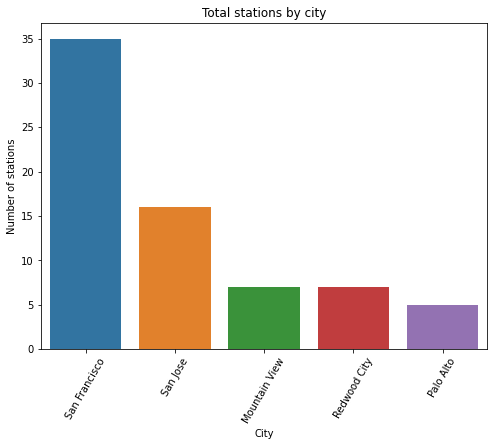

In [ ]:
#barplot of total stations in each city
plt.figure(figsize=(8,6))
sns.barplot(x = "city", y = "Total stations", data = stations_city, dodge = True)
plt.xlabel("City")
plt.xticks(rotation=60)
plt.ylabel("Number of stations")
plt.title("Total stations by city")

The barplot above shows city on the x-axis and number of stations on the y-axis. This concurs with what we observed in the first map where San Franscisco had the greatest number of bike share stations. Despite having the longest trip duration on average when compared to the other cities, Palo Alto has the fewest number of stations.

### Relationship Between Dock Count and Station

Text(0.5, 1.0, 'Dock count by station')

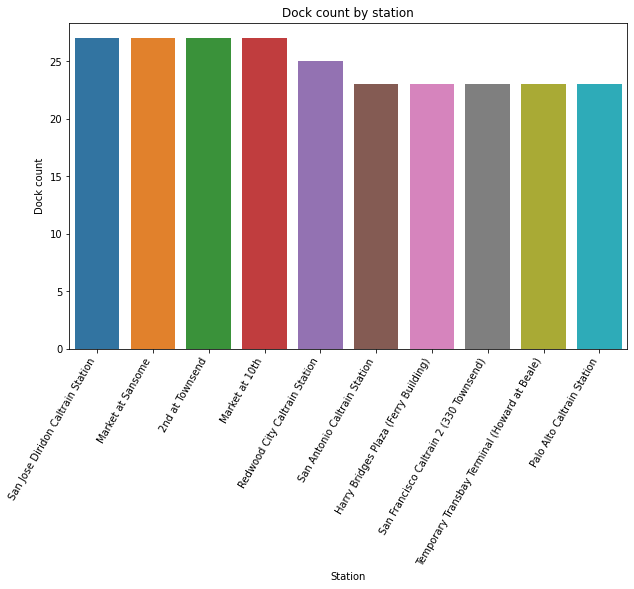

In [ ]:
#sort dock counts across stations
dock_counts = station_df.sort_values(by='dock_count', ascending=False)
dock_counts = dock_counts.head(10)

#barplot of stations with top 10 largest dock counts
plt.figure(figsize=(10, 6))
sns.barplot(x = "name", y = "dock_count", data = dock_counts)
plt.xlabel("Station")
plt.xticks(rotation=60, ha='right')
plt.ylabel("Dock count")
plt.title("Dock count by station")

In the figure above, we plot the top 10 stations with the highest dock count. Among the top 10 stations, each station has a relatively similar dock count, ranging from 23 to 27 bike docks.

In [ ]:
#group by city and name and calculate total dock count
docks_stations = station_df.groupby(['city', 'name'])['dock_count'].sum().reset_index()
docks_stations = docks_stations.sort_values(by = ['city', 'dock_count'], ascending = (True, False))

#get top 5 stations per city
docks_stations = docks_stations.groupby(['city']).head(5)
docks_stations.columns = ['city', 'station_name', 'dock_count']

docks_stations.head()

,city,station_name,dock_count
2,Mountain View,Mountain View Caltrain Station,23
5,Mountain View,San Antonio Caltrain Station,23
1,Mountain View,Evelyn Park and Ride,15
3,Mountain View,Mountain View City Hall,15
4,Mountain View,Rengstorff Avenue / California Street,15


<Figure size 1080x576 with 0 Axes>

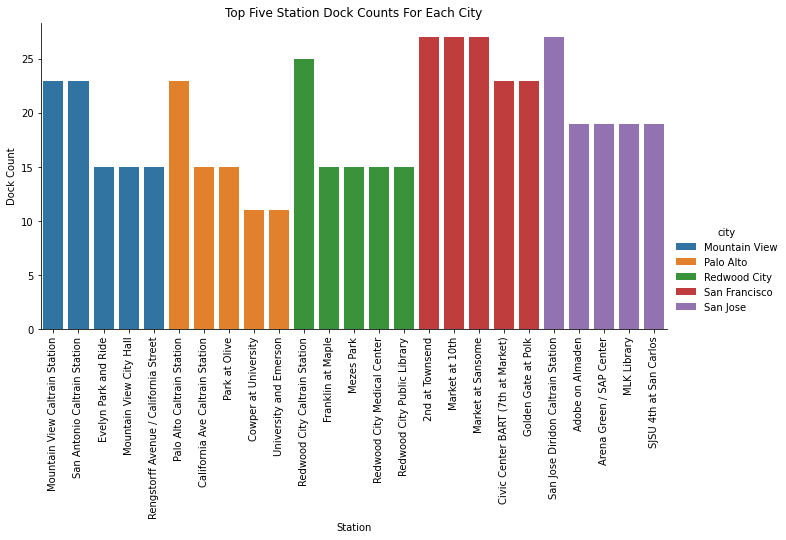

In [ ]:
#plot top 5 station doct counts for each city
plt.figure(figsize=(15,8))
ax = sns.catplot(x= "station_name", y= "dock_count", kind="bar", hue = "city",
            data = docks_stations, height = 5, aspect = 2, dodge=False)
plt.xticks(rotation = 90)
ax.set(title='Top Five Station Dock Counts For Each City')
ax.set(xlabel='Station')
ax.set(ylabel='Dock Count')

In the figure above, we see where the stations with the highest dock counts are located. Three of the four stations with the highest dock counts were located in San Francisco.

### Popular Starting & Ending Stations

In [ ]:
#group by start station and count total trips
popular_start_stations = train_df.groupby('start_station_name').size().reset_index()
popular_start_stations.rename(columns={0: "Total trips"}, inplace=True)
popular_start_stations = popular_start_stations.sort_values(by='Total trips', ascending=False)

#look at top 10 stations
popular_start_stations = popular_start_stations.head(10)
popular_start_stations

,start_station_name,Total trips
51,San Francisco Caltrain (Townsend at 4th),38290
52,San Francisco Caltrain 2 (330 Townsend),26574
24,Harry Bridges Plaza (Ferry Building),23576
68,Temporary Transbay Terminal (Howard at Beale),20590
2,2nd at Townsend,19924
18,Embarcadero at Sansome,19166
69,Townsend at 7th,18647
67,Steuart at Market,18603
30,Market at Sansome,18129
28,Market at 10th,15318


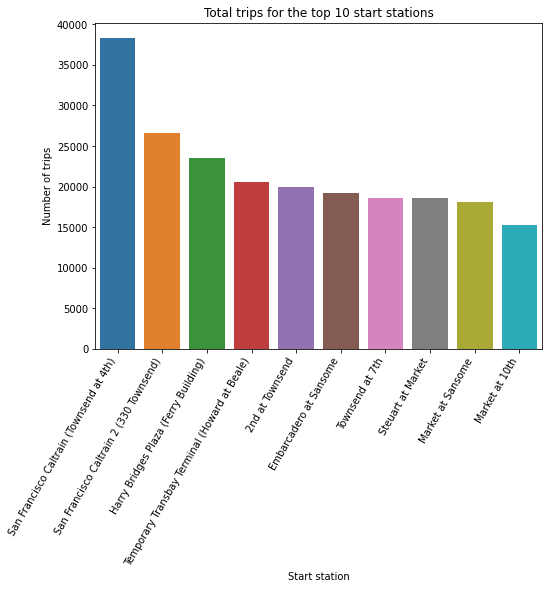

In [ ]:
#plot the top 10 most popular start stations
fig = plt.figure(figsize=(8,6))
sns.barplot(x = "start_station_name", y = "Total trips", data = popular_start_stations, dodge = True)
plt.xlabel("Start station")
plt.xticks(rotation=60, ha='right')
plt.ylabel("Number of trips")
plt.title("Total trips for the top 10 start stations")
fig.align_xlabels()

The figure above shows the total number of trips by starting stations. The San Francisco Caltrain (Townsend at 4th Station) has the most trips as the starting station.

In [ ]:
#group by end station and count total trips
popular_end_stations = train_df.groupby('end_station_name').size().reset_index()
popular_end_stations.rename(columns={0: "Total trips"}, inplace=True)
popular_end_stations = popular_end_stations.sort_values(by='Total trips', ascending=False)

#look at top 10 stations
popular_end_stations = popular_end_stations.head(10)
popular_end_stations

,end_station_name,Total trips
51,San Francisco Caltrain (Townsend at 4th),49408
52,San Francisco Caltrain 2 (330 Townsend),27691
24,Harry Bridges Plaza (Ferry Building),24227
2,2nd at Townsend,21923
30,Market at Sansome,21423
69,Townsend at 7th,20976
18,Embarcadero at Sansome,20685
67,Steuart at Market,18845
68,Temporary Transbay Terminal (Howard at Beale),17597
29,Market at 4th,14445


Text(0.5, 1.0, 'Total trips for the top 10 end stations')

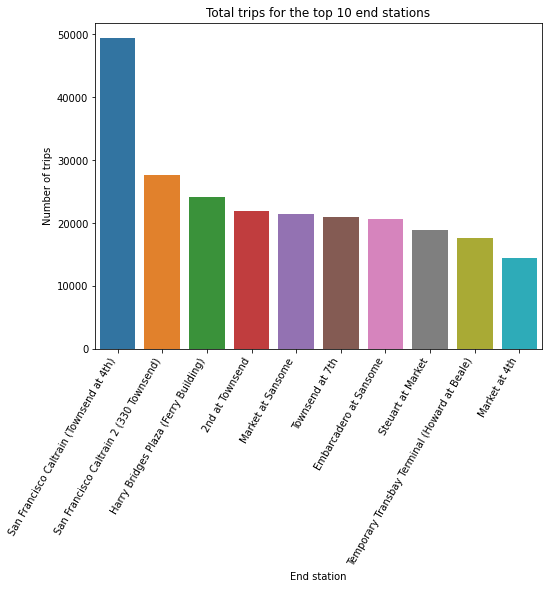

In [ ]:
#plot the top 10 most popular start stations
plt.figure(figsize=(8,6))
sns.barplot(x = "end_station_name", y = "Total trips", data = popular_end_stations, dodge = True)
plt.xlabel("End station")
plt.xticks(rotation=60, ha='right')
plt.ylabel("Number of trips")
plt.title("Total trips for the top 10 end stations")

The figure above shows the total number of trips by ending stations. The San Francisco Caltrain (Townsend at 4th Station) has the most trips as the ending station, too. From the information we gathered about starting and ending station, we assume this station to be very busy and popular.

### K-means Clustering

Based on our exploratory data analysis, we noticed interesting trends between specific stations, trip counts, and trip durations. In order to inform Bay Wheels on strategic and targeted allocation of system improvements, we can identify key stations that are in high demand or have high usage intensity (i.e. long trip duration). To do this, we can determine the stations that exhibit similar characteristics with each other, with regards to station usage and intensity. We can employ k-means clustering, an unsupervised learning method, to determine unique clusterse of stations that exhibit similar features. We choose to cluster on the variables: total trips per start station and average trip duration per station.

#### Data Preparation



In this section, we first prepare the dataset for the k-means clustering model. We perform data preprocessing as well as feature scaling, because k-means clustering is not a scale-invariant method. In our preprocessing steps, we create the features: total trips per station and average trip duration per station. We also address any null values and drop them accordingly. <br>

**Note:** We only use the training dataset for k-means clustering as in real-world situations, we would only have access to the training data.

In [ ]:
#group by start station and calculate total trips
k_means_stations = train_df.groupby('start_station_name').size().reset_index()
k_means_stations.rename(columns={0: "total_trips"}, inplace=True)
k_means_stations = k_means_stations.sort_values(by='total_trips', ascending=False)

In [ ]:
#group by start station and calculate average trip duration
station_duration = train_df.groupby('start_station_name')['duration'].mean().sort_values(ascending=False).reset_index()
station_duration.head()

,start_station_name,duration
0,University and Emerson,45.948259
1,California Ave Caltrain Station,23.371377
2,Park at Olive,21.191806
3,San Jose Civic Center,20.917916
4,Palo Alto Caltrain Station,18.338142


In [ ]:
#merge the k_means_stations dataframe with station_duration
k_means_stations = pd.merge(k_means_stations, station_duration, how='left', left_on=['start_station_name'], right_on = ['start_station_name'])

k_means_stations.columns

Index(['start_station_name', 'total_trips', 'duration'], dtype='object')

In [ ]:
#check for null values
k_means_stations.isnull().sum()

start_station_name    0
total_trips           0
duration              0
dtype: int64

Since k-means clustering is an algorithm that is affected by the scale of the features, we need to perform feature scaling to ensure that the features are all on the appropriate scale.

In [ ]:
#select the features
features = k_means_stations.drop(columns=['start_station_name'])

In [ ]:
#scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#### Find the Optimal k Clusters

We want to determine the optimal number of clusters. To do this, we will run k-means clustering for different values of k (number of clusters) and see how well the clusters fit the data. We use the 'elbow method' in which we run k-means clustering with different k values and plot the distortion (sum of the squared distances between the point and centroid) vs. k. We will then find an ‘elbow’ where the distortion flattens out.

In [ ]:
#loop through values of k = 1 to k = 15 and plot the distortion
sse = []
for k in range(1, 15):
  #run k-means clustering
  kmeans = KMeans(n_clusters=k, random_state = 123)
  #fit
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

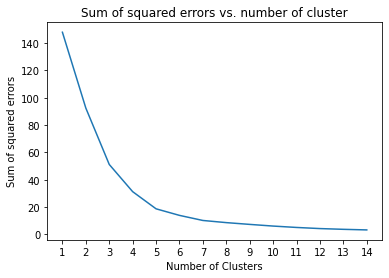

In [ ]:
#plot the sum of squared errors vs the number of clusters
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared errors")
plt.title("Sum of squared errors vs. number of cluster")
plt.show()

To sense check our results, it makes sense that the sum of squared errors decrease as the number of clusters increases. In the next cell, we use the *kneed* package to determine where the 'elbow' in the plot is.

In [ ]:
# the elbow occurs at k = 5
kl = KneeLocator(range(1, 15), sse, curve="convex", direction="decreasing")
kl.elbow

5

We can now run k-means clustering with this optimal value at k = 5 and analyze the results.

In [ ]:
# run k-means for k=5 and fit
kmeans_5_clusters = KMeans(n_clusters = 5, random_state = 123)
kmeans_5_clusters.fit(scaled_features)

KMeans(n_clusters=5, random_state=123)

In [ ]:
# cluster output
labels = kmeans_5_clusters.labels_
print(kmeans_5_clusters.labels_)

[3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 4 4 4 0 0
 4 4 4 4 4 4 4 4 4 0 0 4 4 4 4 4 4 4 4 0 0 4 4 2 4 0 0 0 0 0 4 4 0 0 0 0 0]


In [ ]:
#append the cluster labels to the original dataframe
k_means_stations['clusters'] = labels
k_means_stations.head()

,start_station_name,total_trips,duration,clusters
0,San Francisco Caltrain (Townsend at 4th),38290,11.217133,3
1,San Francisco Caltrain 2 (330 Townsend),26574,9.846581,3
2,Harry Bridges Plaza (Ferry Building),23576,14.311505,3
3,Temporary Transbay Terminal (Howard at Beale),20590,9.167800,3
4,2nd at Townsend,19924,10.265782,3


#### Cluster Analysis

We now have identified the optimal cluster groupings based on similarity with regards to total number of trips per station and average trip duration per station. In this section, we analyze the results from the k-means clustering model.

In [ ]:
#group by cluster and calculate total points
stations_clusters = k_means_stations.groupby('clusters').size().reset_index()
stations_clusters.rename(columns={0: "Total in cluster"}, inplace=True)
stations_clusters

,clusters,Total in cluster
0,0,17
1,1,22
2,2,1
3,3,9
4,4,25


Text(0, 0.5, 'Total in cluster')

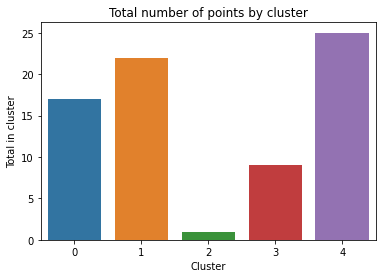

In [ ]:
#plot the total points in each cluster
plt.figure(figsize=(6,4))
sns.barplot(x = "clusters", y = "Total in cluster", data = stations_clusters, dodge = True)
plt.xlabel("Cluster")
plt.title("Total number of points by cluster")
plt.ylabel("Total in cluster")

In [ ]:
#which station is in cluster 2?
k_means_stations[k_means_stations['clusters'] == 2]

,start_station_name,total_trips,duration,clusters
60,University and Emerson,919,45.948259,2


In the figure above, we plot the cluster number on the x-axis and total number of stations in each cluster on the y-axis. We can see that cluster 4 has the most number of stations (n = 25) while cluster 2 only contains one station (n = 1). We can see that the University and Emerson station in Palo Alto is the only station in cluster 2. We know from the exploratory data analysis sections that the University and Emerson station is the station with the longest average trip duration. Thus because it is so extreme, it is in its own cluster. We can further examine the data within each cluster to determine further characteristics:

Text(0.5, 1.0, 'Cluster groupings of stations by average trip duration and total trips')

<Figure size 576x432 with 0 Axes>

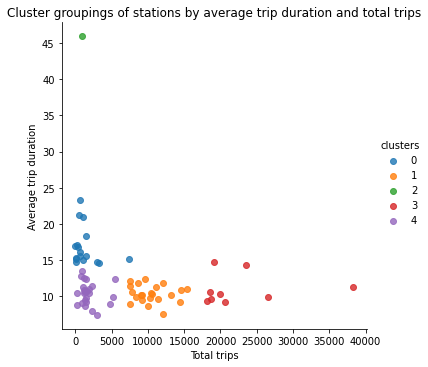

In [ ]:
#scatter plot of stations by cluster group
plt.figure(figsize=(8,6))
sns.lmplot(x="total_trips", y="duration", hue='clusters', data = k_means_stations, fit_reg = False)
plt.xlabel("Total trips")
plt.ylabel("Average trip duration")
plt.title("Cluster groupings of stations by average trip duration and total trips")

In the figure above, we see the five cluster groupings of stations with average trip duration by station on the y-axis and total trips on the x-axis. We observe that stations in Cluster 0 have the lowest number of total trips by station, and an average trip duration that ranges from 15 - 25 minutes. Cluster 1 has the second largest number of total trips but low trip duration. Cluster 2 contains one setation that has the lowest number of total trips but extremely high average trip duration. Cluster 3 contains stations with a large number of total trips but low average trip duration, indicating high frequency of usage but low intensity. Cluster 4 has stations with both low trip intensity and trip usage.

We can further examine characteristics of each of the clusters:

Text(0.5, 1.0, 'Distribution of bike share trip duration by cluster')

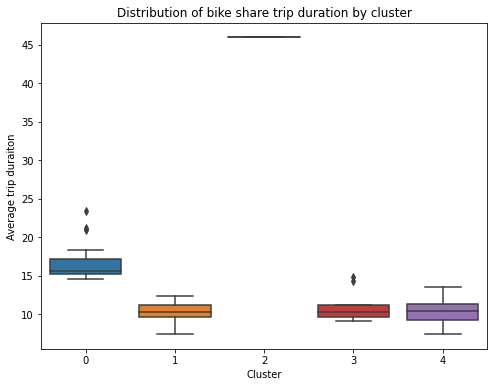

In [ ]:
#plot the distribution of trip durations for each cluster
plt.figure(figsize=(8,6))
sns.boxplot(data=k_means_stations, x="clusters", y="duration")
plt.xlabel("Cluster")
plt.ylabel("Average trip duraiton")
plt.title("Distribution of bike share trip duration by cluster")

In the figure above, we plot boxplots of trip duration for each of the 5 clusters. Recall that cluster 2 only has 1 station, so we only see a horizontal line as its boxplot. From the figure, it appears that cluster 1, 3, and 4 exhibit similar trends in their trip duration distributions, with the average across stations around 10 minutes. Cluster 0 has an average trip duration around 15 minutes and features overall higher average trip durations.

Text(0.5, 1.0, 'Distribution of total trips by cluster')

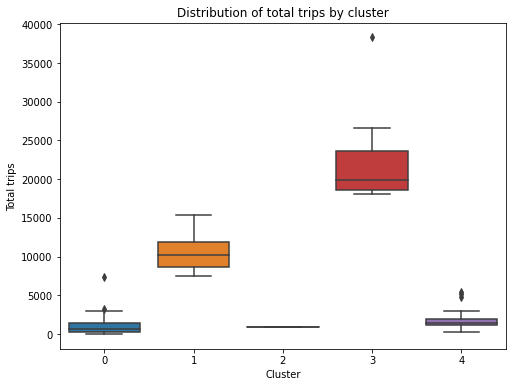

In [ ]:
#plot the distribution of total trips for each cluster
plt.figure(figsize=(8,6))
sns.boxplot(data=k_means_stations, x="clusters", y="total_trips")
plt.xlabel("Cluster")
plt.ylabel("Total trips")
plt.title("Distribution of total trips by cluster")

In the figure above, we plot boxplots of total trips by station for each of the 5 clusters. Recall that cluster 2 only has 1 station, so we only see a horizontal line as its boxplot. From the figure, it appears that clusters 0 and 4 exhibit similar trends in their total trip distributions. Cluster 1 has the second largest number of total trips on average, while stations in cluster 3 have the most overall total trips.

In [ ]:
#summary table for clusters
stations_summary = k_means_stations.groupby('clusters')['total_trips', 'duration'].mean().reset_index()
stations_summary

<ipython-input-122-55e07d3c2b47>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stations_summary = k_means_stations.groupby('clusters')['total_trips', 'duration'].mean().reset_index()


,clusters,total_trips,duration
0,0,1292.647059,16.864641
1,1,10439.409091,10.334362
2,2,919.000000,45.948259
3,3,22611.000000,11.009891
4,4,1834.880000,10.424207


From the k-means clustering results, we can identify several groupings of stations that exhibit similar trends in total trip counts and average trip duration. Overall, we see that the University and Emerson station in Palo Alto (Cluster 2) shows the most unique behavior with having the highest trip duration out of all the stations and clusters, thus indicating the most intensity of usage. Other cluster groupings indicate stations with lower average duration but higher total trips (Cluster 3) versus stations with higher average duration but lower total trips (Cluster 0). Because the University and Emerson station has the most intense usage (highest average trip duration), further enhancements can be directed towards accomodating this high trip intensity. Additionally, stations that have similar total trip counts and average trip duration trends can receive certain improvements that are specifically targeted towards those stations. <br>

Initially, we had considered incorporating these cluster groupings as features into our prediction model of bike share trip duration. However, recall that we implemented k-means clustering for the training data. Since the data is split into training and testing, if we perform k-means on the training data to identify clusters, we may not get the same clusters for the testing data. Thus we decide to leave out the clusters as features in our prediction models and proceed with using the other features to develop models that predict bike share trip duration.

# Regression Models

## Feature Engineering and Selection

We based our EDA on the guiding question: **How can we predict the duration of a bike share rental?** From our exploration, we have an idea on which features to select for training our model, based on trends and patterns we deemed interesting.

These features include:

*   *subscription_type*: binary categorical data split between subscription holder and regular customer
*   *month*: the month in which the bike share trip occured in
*   *city*: city where station is located
*   *weekday_or_weekend*: binary categorical data split between weekday trips and weekend trips
*   *time_of_day*: the time frame (binned) in which the trip occured
*   *events*: recorded weather phenonmena

We mostly drop all of the numerical weather data as features because this showed very low correlations with trip duration. In this section, we one hot encode these variables and prepare them for model building.

In [ ]:
#subset the features
trip_station_df_train = train_df[['duration', 'city', 'subscription_type', 'month', 'weekday_or_weekend', 'events', 'time_of_day']]
trip_station_df_test = test_df[['duration', 'city', 'subscription_type', 'month', 'weekday_or_weekend', 'events', 'time_of_day']]

### One-Hot Encoding

We need to one-hot encode all our categorical variables. This will transform our current categorical features into binary feature vectors, which will be important in our regression steps.

In [ ]:
'''
This function one-hot encodes the categorical variables of interest for the training
and testing dataframes in-place. It requires the training, testing, and variable name
as arguments.
'''

def one_hot_encode(train_df, test_df, category):
  encoder = OneHotEncoder()
  encoded_columns = encoder.fit_transform(train_df[[category]]).toarray()
  new_columns = encoder.categories_[0]
  train_df[new_columns] = encoded_columns

  encoder_test = OneHotEncoder()
  cols_test = encoder_test.fit_transform(test_df[[category]]).toarray()
  test_cols = encoder_test.categories_[0]
  test_df[test_cols] = cols_test

In [ ]:
#one hot encode the features for both the training and testing sets
one_hot_encode(trip_station_df_train, trip_station_df_test,'weekday_or_weekend')
one_hot_encode(trip_station_df_train, trip_station_df_test,'time_of_day')
one_hot_encode(trip_station_df_train, trip_station_df_test,'month')
one_hot_encode(trip_station_df_train, trip_station_df_test,'subscription_type')
one_hot_encode(trip_station_df_train, trip_station_df_test,'events')
one_hot_encode(trip_station_df_train, trip_station_df_test,'city')

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
#drop columns we don't need after one hot encoding
trip_station_df_train = trip_station_df_train.drop(['city', 'subscription_type', 'month', 'weekday_or_weekend', 'events', 'time_of_day'], axis=1)
trip_station_df_test = trip_station_df_test.drop(['city', 'subscription_type', 'month', 'weekday_or_weekend', 'events', 'time_of_day'], axis=1)

In [ ]:
trip_station_df_train.columns

Index(['duration', 'weekday', 'weekend', 'afternoon', 'early_morning',
       'evening', 'late_night', 'morning', 'night', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'Customer', 'Subscriber', 'Fog',
       'Fog-rain', 'Normal', 'Rain', 'Rain-thunderstorm', 'Mountain View',
       'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose'],
      dtype='object')

Here, we are able to see that the chosen categorical variables have succesfully been numerically encoded.

We split our data into x (features) and y (target) for both the train and test sets

In [ ]:
#split into x and y training and testing
x_train = trip_station_df_train.drop(['duration'], axis=1).to_numpy()
y_train = trip_station_df_train['duration'].to_numpy()

x_test = trip_station_df_test.drop(['duration'], axis=1).to_numpy()
y_test = trip_station_df_test['duration'].to_numpy()

### Dimensionality Reduction

We were initally considering using PCA for dimensionality reduction to choose which features were the most important for our model. However, since PCA is most suitable for numerical variables (categorical variables do not have a variance structure) that have strong correlations with each other. In our exploratory data analysis, we found that the numerical weather columns have relatively low correlations with each other and those features that were more stongly correlated with each other had 0 correlations with duration. If we were to run PCA it is likely that we would find that all of the uncorrelated features would be removed. Because of this, we only kept the events feature from the weather dataframe in our model, and performed dimensionality reduction manually, since PCA was not well suited to our particular problem.

## Predicting Bike Share Trip Duration

At this point, the training and test data have been split into *x_train*, *x_test*, *y_train*, and *y_test* with each of the 'y' dataframes containing a single column (duration) which is the continuous target value. *X_train* and *X_test* contain the features that describe whether the traveler booking the bike share was a subscriber or customer, the city the trip originated in, the day of week, month, time of day of the trip, and the weather on the day of the trip.

### Linear Regression


In the next cell, we perform a simple linear regression to predict the bike share trip duration. We evaluate the model using the R-squared (R^2) score, which measures how much variability in the dependent variable is explained by the model.

In [ ]:
#fit and predict
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

#r2 score
score = r2_score(y_test, y_pred)
print("R2 for the test data is: " + str(score))

score = r2_score(y_train, reg.predict(x_train))
print("R2 for the train data is: " + str(score))

R2 for the test data is: 0.00027504638659481273
R2 for the train data is: 0.22098701801192833


When fitting the data with a basic linear regression model, the R^2 score is very low (around 0.000275) and the model is not fitting the data well. By looking at the training error as well, we see that the R^2 score is also very low, so this would suggest that there may be some underfitting. <br>

Underfitting would suggest that the models we are using are not complex enough to explain the relationship between the features and target variable. Thus we want to try more complex models, for example, polynomial regression, random forests, and gradient boost regression. These models may potentially lower the bias and increase the complexity of the model.

### Polynomial Regression

In [ ]:
#regression with polynomial features
poly = PolynomialFeatures(2)
poly.fit_transform(x_train)

#fit and predict
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

#R2 score
score = r2_score(y_test, y_pred)
print("R2 for the test data is: " + str(score))

score = r2_score(y_train, reg.predict(x_train))
print("R2 for the train data is: " + str(score))

R2 for the test data is: 0.00027504638659481273
R2 for the train data is: 0.22098701801192833


The polynomial regression model performed the same as the linear regression model, thus indicating that this parameteric structure may not be well-suited to fit the data. We want to try a few further models to lower the bias term and increase model complexity, thus potentially addressing this underfitting issue.

### Gradient Boosting Regression

In [ ]:
#fit and predict
reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

#R2 score
score = r2_score(y_test, y_pred)
print("R2 for the test data is: " + str(score))

score = r2_score(y_train, reg.predict(x_train))
print("R2 for the train data is: " + str(score))

R2 for the test data is: 0.00027014144373527227
R2 for the train data is: 0.2388970288358505


The gradient boosting regression model performs worse than the linear regression and polynomial regression models, with a very low R^2 for the test data. Before pivoting towards a new class of models, we try a random forests model to see if there is any improvement.

### Random Forest Regression

In [ ]:
#fit and predict
reg = RandomForestRegressor(max_depth=2)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

#R2 score
score = r2_score(y_test, y_pred)
print("R2 for the test data is: " + str(score))

score = r2_score(y_train, reg.predict(x_train))
print("R2 for the train data is: " + str(score))

R2 for the test data is: 0.00027870116606321105
R2 for the train data is: 0.22164770227644426


We see that random forest performed the best out of all of the regression models so far, which is expected. The R^2 for the test data is the highest, yet still very low. In the next section, we analyze why this is the case and present a new class of models to predict bike share trip durations.

## Analysis of Models

In this section, we discuss why our regression models to predict bike share trip duration are not performing well and how we can address these issues in a new class of models.

- From observing the outputs of our linear regression models, we observe that the R^2 (coefficient of correlation) values were all less than 0.1, indicating that less than 10% of the variation in the data was able to be explained by any one of our models. After observing these initial results, we tried a variety of models and tried to improve the performance of our current models through cross validation and grid search cross validation to try to find the best hyperparameter values for our models. However, this yielded very similar results with essentially no improvement, so we decided to regroup and evaluate why this may be happening at a high level. The first thing we discussed was that our dataset may not be best suited for regression. After reducing the dimensionality of the features by creating correlation matrices between the features and the dependent variable (duration), we were left with solely categorical features that we one-hot encoded to predict trip duration. Although regression models in sklearn don’t distinguish between numerical and categorical features, assigning weights to the features based solely on 0 or 1 values will inherently make the model underperform, due to the fact that there is not a single numerical feature included in the model to help counter this effect. We then performed additional feature engineering and included features such as time of day prior to rerunning our models. We found that this also was unsuccessful in improving model accuracy and the coefficient of determination.

- The next thing we did was to go over our entire code a couple of times and we realized that linear regression may simply not be powerful enough to fit our complicated data set. This could be due to the differences in the distribution of data for each city, the differences in the distribution data for each start/end station, as well as differences in user behavior based on the time of year, how much daylight there is on a given day, and differences in temperature (which are not captured in our dataset as explained in a section above where we created a correlation heatmap).

- A third observation we made was that the data is similar to, but not exactly the same as, time series data, since the information regarding bike share trips is given on a daily basis. Hidden variables, in addition to the month, day of week and time of day may include: seasons, whether a particular day is a holiday or not, information regarding the number of hours of daylight remaining at the time the trip was taken, traffic on the roads of the route a person took at a given time, and the speed at which the person rode their bike. These are all factors that the duration of the trip would heavily depend on, as well as the particular day itself. From class, we know that most machine learning models, including regression, are not well suited to this problem, and since we do not have a large number of features in our dataset that we are considering, it is unlikely that trying out neural networks would suit the problem better.

# Classification

Due to the above reasons and the ultimate objective of making a model that will be useful to our target client, the Bay Wheels bike share system, we decided to switch to a classification problem. We will start by thresholding the duration such that any duration values below the threshold will be classified as a **short** trip, and any value above will be classified as a **long** trip. This is essentially performing a very similar task to our earlier regression problem, however we group the durations such that the data is less complex and more suitable for training our model and will provide similar insights on trip durations. We decided to narrow our scope of our problem to an individual city, since we hypothesize that the variations for each city are too complex to be demonstrated by a single model. <br>


**Please note that certain sections of our work for Classification may not be as extensive as for Regression since we are working with prior intuition from the previous sections and are building off of them.**

## Data preparation

### Splitting the data for Palo Alto

From our rationale of why we choose to switch to classification, we noted that our linear regression models were severely underperforming, most likely to due to the parametric structure of the model being too simple to explain the complexities of our data. In our regression models, we were aggregating the data across the entire Bay Area which may have resulted in some underfitting as we were not able to explain complexities across cities. In order to address this issue and obtain useful results for our end user, we want to implement our classification for one city only. <br>

Recall from our EDA in the regression section that we noticed that out of all of the cities, Palo Alto had the largest variation in the data between trip duration and weather events, as well as by subscription type and stations. Additionally in our k-means clustering analysis, we found that the University and Emerson station in Palo Alto was in its own cluster, based on its long average trip duration and total trip count. Thus with Palo Alto having the most variation among the average trip duration, as well as having the most intensely used station, Palo Alto would be a good choice of city to narrow the scope to for the model building process. By choosing similar features as our linear regression model, we feel as though we could better explain short vs. long trip durations in classification model by building our model for Palo Alto. It is critical to note that this model and pipeline can be generalized to any city in our data set, but additionally for the purposes of readiability, we focus on executing a model for the Palo Alto area. Future work will plan to expand the geographic scope of our model and incorporate more cities in the San Francisco Bay area.

We use **tws_df** as the starting point for classification since it is the resulting dataframe of merging **trip_df**, **weather_df**, and **station_df**. We split the combined dataframe to contain trips for Palo Alto only.

In [ ]:
palo_alto_df = tws_df[tws_df['city'] == 'Palo Alto']

### Train Test Split For Palo Alto

Now that we have the dataframe for Palo Alto, we want to split this into train and test sets prior to performing any data cleaning or model building. This is because we will treat the training data as data that we previously have, and the testing data as data that we do not yet have that will be used to evaluate the models.

In [ ]:
palo_alto_train, palo_alto_test = train_test_split(palo_alto_df, test_size=0.2, random_state = 123)

## Data Cleaning

We will start by performing a simple check of the datafames to see how many features have null values and will come up with strategies for filling them or dropping the rows with nulls.

In [ ]:
#check the nulls in the training data
print('Palo Alto\n', palo_alto_test.isnull().sum())

Palo Alto
 trip_id                              0
duration                             0
start_date                           0
time                                 0
start_station_name                   0
start_station_id                     0
start_lat                            0
start_long                           0
city                                 0
zip_code                             0
end_date                             0
end_station_name                     0
end_station_id                       0
end_lat                              0
end_long                             0
dock_count                           0
installation_date                    0
bike_id                              0
subscription_type                    0
billing_zip_code                    27
max_temperature_f                    0
mean_temperature_f                   0
min_temperature_f                    0
max_dew_point_f                      0
mean_dew_point_f                     0
min_dew_point_

### Preprocessing Data

In this section, we are making use of the preprocessing functions previously defined in the regression section for data imputation for both the training and testing sets prior to EDA, since we previously discussed that those methods of imputation seem the most logical for the features with null values. These functions are called below, and will fill in the previously identified null values appropriately for the train and test dataframes.

**Note**: For imputation relying on groupbys or calculating means, test data imputation will rely on the mean/groupby/other aggregate values from the training data, since we can think of the test data as being run by the model one row (data instance) at a time, so it wouldn't make sense for us to compute aggregate values from the test set.

In [ ]:
'''Data Cleaning for Palo Alto'''

#impute the weather data for max_gust_speed_mph
palo_alto_train['max_gust_speed_mph'] = impute_weather_train(palo_alto_train, 'max_gust_speed_mph')
palo_alto_test['max_gust_speed_mph'] = impute_weather_test(palo_alto_test, 'max_gust_speed_mph', palo_alto_train['max_gust_speed_mph'].mean())

#clean events column
palo_alto_train['events'] = normal_events(palo_alto_train, 'events')
palo_alto_test['events'] = normal_events(palo_alto_test, 'events')

#clean billing zip code column
palo_alto_train = billing(palo_alto_train, 'billing_zip_code')
palo_alto_test = billing(palo_alto_test, 'billing_zip_code')

#convert trip duration into minutes
palo_alto_train['duration'] = palo_alto_train['duration']/60
palo_alto_test['duration'] = palo_alto_test['duration']/60

#create a month column in the train and test data sets
palo_alto_train['month'] = palo_alto_train['start_date'].apply(lambda x: calendar.month_name[x.month])
palo_alto_test['month'] = palo_alto_test['start_date'].apply(lambda x: calendar.month_name[x.month])

#create a day of week column in the train and test data sets
palo_alto_train['day_of_week'] = palo_alto_train['start_date'].apply(lambda x: calendar.day_name[x.weekday()])
palo_alto_test['day_of_week'] = palo_alto_test['start_date'].apply(lambda x: calendar.day_name[x.weekday()])

palo_alto_train['time_of_day'] = palo_alto_train['time'].apply(lambda x: binning_time(x))
palo_alto_test['time_of_day'] = palo_alto_test['time'].apply(lambda x: binning_time(x))

<ipython-input-33-d51f3600528a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: clean_zip_code(x))


In [ ]:
#check the nulls in the training and test data
print('Palo Alto train', palo_alto_train.isnull().sum())
print('Palo Alto test', palo_alto_test.isnull().sum())

Palo Alto train trip_id                           0
duration                          0
start_date                        0
time                              0
start_station_name                0
start_station_id                  0
start_lat                         0
start_long                        0
city                              0
zip_code                          0
end_date                          0
end_station_name                  0
end_station_id                    0
end_lat                           0
end_long                          0
dock_count                        0
installation_date                 0
bike_id                           0
subscription_type                 0
billing_zip_code                  0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidit

### Cleaning trip duration

Since we will be thresholding the duration data for classification, we would like to observe the distribution of the data for duration to make sure there are no outliers that may affect our thresholding value and our models.

Text(0.5, 1.0, 'Distribution of trip duration')

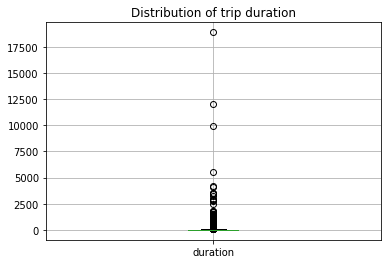

In [ ]:
palo_alto_train.boxplot(['duration'])
plt.title("Distribution of trip duration")

We observe that the data are heavily skewed right are likely to contain outliers. We will remove these outliers so that they do not influence the weights of our models and result in incorrect classification in the general case (non outlier test data).

In [ ]:
#remove outliers
q_low = palo_alto_train['duration'].quantile(0.01)
q_high  = palo_alto_train['duration'].quantile(0.99)

palo_alto_train = palo_alto_train[(palo_alto_train['duration'] < q_high) & (palo_alto_train['duration'] > q_low)]

We will check the distributions of the data without outliers and see how they look.

Text(0.5, 1.0, 'Distribution of trip duration')

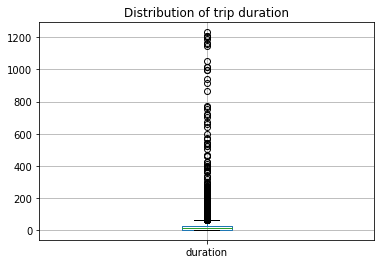

In [ ]:
palo_alto_train.boxplot(['duration'])
plt.title("Distribution of trip duration")

We removed the outliers present in the data, and the distribution of trip durations look much more reasonable to work with, so we will proceed with this data frame.

## Additional EDA

Since we have now cleaned and preprocessed our data, we would like to explore it further to understand general trends in the Palo Alto data. Many of the plots here have been broken down by city in the EDA for linear regression, and including the plots for all 5 cities is a bit overwhelming to read, so we will only be visualizing the Palo Alto data.

We also only perform exploratory data analysis on the **training** data since in real world situations, this is all we would have access to. It is assumed that the test data are not seen until they are used to evaluate the models, and we would not have any knowledge of the distribution or characteristics of the test data.

**Our guiding question for this section is:** How can we predict whether a bike share trip will be a short trip or a long trip in Palo Alto? <br>

Potential questions to explore:
*   How long are trips on average?
*   What does the **distribution** of trip durations look like?
*   How does the **distribution** of trip durations vary across days, months, etc.?
*   How does weather impact bike trip durations?
*   How do bike trip patterns vary by time of day and the day of the week?
*   Which month/day has the most number of trips?
*   What stations are more popular?
*   How do we determine what makes a trip short vs. long?
*   Which features are most correlated with trip duration and how might we engineer new ones from the data to emphasize the correlations?

We'd like to view the distribution of duration in the form of density curves to get a better understanding of the variation in duration for Palo Alto.

Text(0.5, 0, 'Average duration')

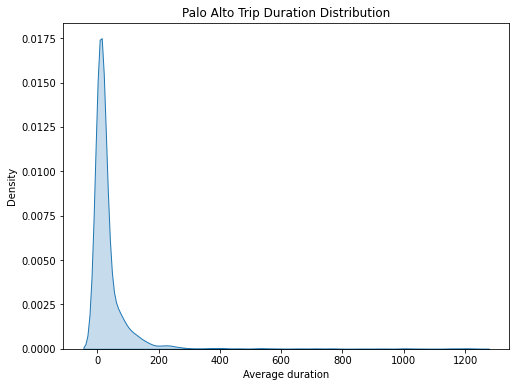

In [ ]:
#density plot of all trip durations in Palo Alto
plt.figure(figsize=(8,6))
sns.kdeplot(palo_alto_train['duration'], shade=True)
plt.title('Palo Alto Trip Duration Distribution')
plt.xlabel("Average duration")

It would also be beneficial to view correlation heatmaps for the numerical data in the dataframes for Palo Alto, which is done below.

Text(0.5, 1.0, 'Correlation Matrix of Numeric Features and Duration for Palo Alto')

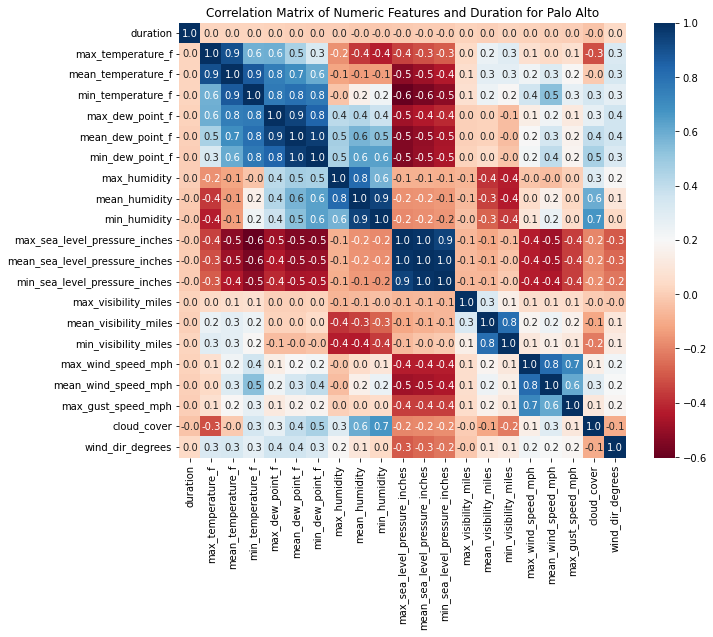

In [ ]:
#plot heatmap of all numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(palo_alto_train[['duration', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'wind_dir_degrees']].corr(), cmap="RdBu", annot=True, fmt=".1f")
plt.title('Correlation Matrix of Numeric Features and Duration for Palo Alto')


We see that the correlations between the weather data and duration are effectively 0, therefore we will likely remove these features for the chosen city in the dimensionality reduction section.

The pie chart below shows the average trip duration for the two different subscription types for Palo Alto.

Text(0, 0.5, '')

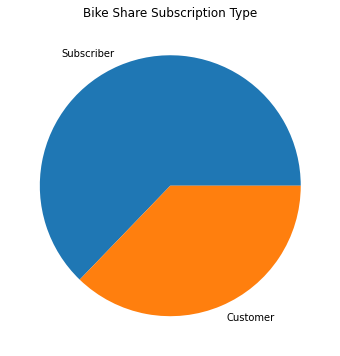

In [ ]:
# pie chart by subscription type
plt.figure(figsize=(8,6))
palo_alto_train['subscription_type'].value_counts().plot.pie()
plt.title("Bike Share Subscription Type")
plt.ylabel("")

Text(0, 0.5, 'Average duration')

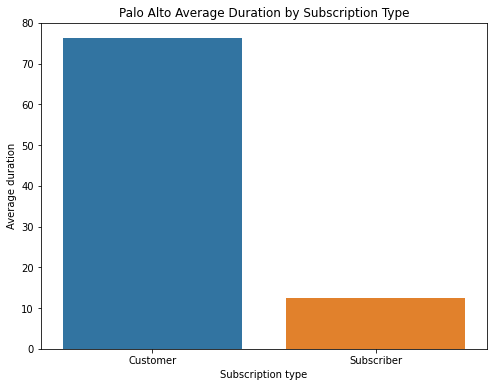

In [ ]:
#bar plot of average trip duration by subscription type
plt.figure(figsize=(8,6))
sns.barplot(x = "subscription_type", y = "duration", data = palo_alto_train.groupby('subscription_type')['duration'].mean().reset_index(), dodge = True)
plt.title('Palo Alto Average Duration by Subscription Type')
plt.xlabel("Subscription type")
plt.ylabel("Average duration")

For the pie chart and bar chart above, we observe that Palo Alto has a high average duration for customers, so this suggests that the data in its distribution are more spread out.

Below, we will view the weather events for each city and view their distribution and how they relate to duration:

Text(0, 0.5, 'Average duration')

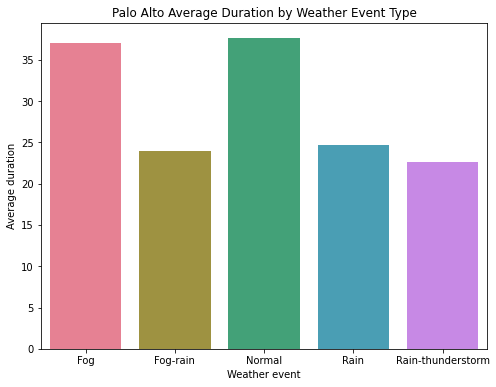

In [ ]:
#barplot of weather events
plt.figure(figsize=(8,6))
sns.barplot(x="events", y='duration', data= palo_alto_train.groupby(['events'])['duration'].mean().reset_index(), dodge=True, palette='husl')
plt.title('Palo Alto Average Duration by Weather Event Type')
plt.xlabel("Weather event")
plt.ylabel("Average duration")

We observe that out of all of the cities, Palo Alto shows variation in the data for the relationship between weather events. We see that normal weather in Palo Alto is associated with higher average durations, while the opposite is true for any 'bad' weather.

Below we've reproduced a graph from our initial EDA:

<Figure size 1080x576 with 0 Axes>

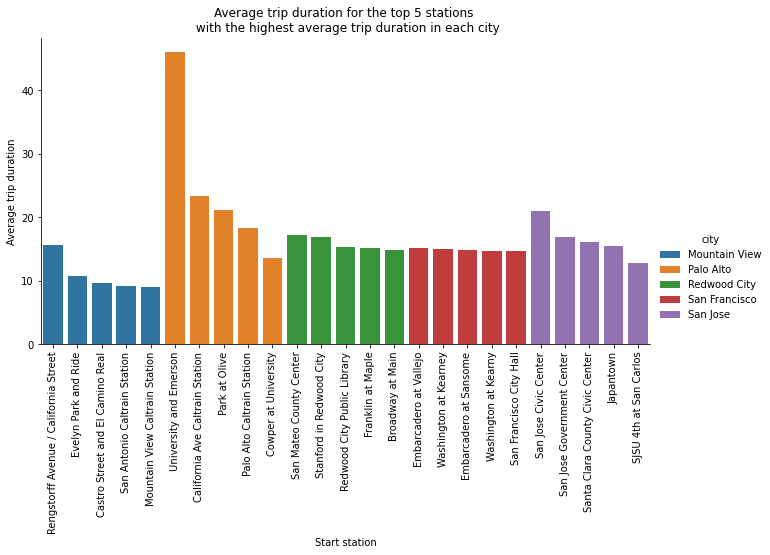

In [ ]:
#group by cities and stations and calculate average duration
cities_stations = train_df.groupby(['city', 'start_station_name'])['duration'].mean().reset_index()
cities_stations.rename(columns={'duration': 'avg_duration'}, inplace=True)

#look at top 5 stations per each city based on average trip duration
cities_stations = cities_stations.sort_values(by='avg_duration', ascending=False).groupby('city').head(5)
cities_stations_top_5 = cities_stations.sort_values(['city', 'avg_duration'], ascending = [True, False])

#bar plot of average trip duration for the top 5 stations with the highest trip duration per city
plt.figure(figsize=(15,8))
ax = sns.catplot(data=cities_stations_top_5, x="start_station_name", y="avg_duration", hue="city", kind="bar", height = 5, aspect = 2, dodge=False)
plt.xticks(rotation=90)
ax.set(ylabel='Average trip duration')
ax.set(xlabel='Start station')
ax.set(title='Average trip duration for the top 5 stations \n with the highest average trip duration in each city')

We observe that Palo Alto has more variation among the average durations for stations as well, which further provides evidence towards Palo Alto being a good choice of city to narrow the scope to for the model building process.

Next we will consider the distribution of duration based on day of week, month, and time_of_day for Palo Alto in the 3 cells below.

Text(0.5, 1.0, 'Distribution of trip durations by month in Palo Alto')

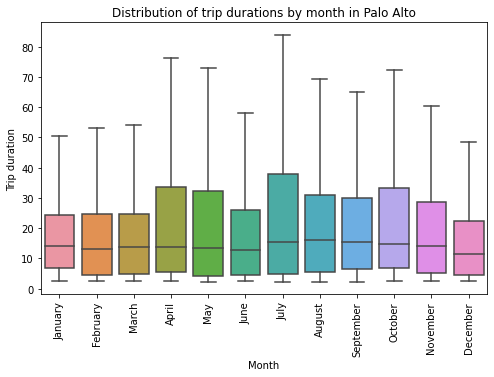

In [ ]:
#bike share trip duration by month
#reorder the months for better visualization
trip_station_df_month = palo_alto_train[["month", "duration"]].sort_values(by = "month")

ordered_months = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

trip_station_df_month['month'] = pd.Categorical(trip_station_df_month['month'], categories = ordered_months, ordered=True)

#boxplot for each month
plt.figure(figsize=(8,5))
sns.boxplot(x = "month", y = "duration", data = trip_station_df_month, showfliers = False)
plt.xlabel("Month")
plt.ylabel("Trip duration")
plt.xticks(rotation=90)
plt.title("Distribution of trip durations by month in Palo Alto")

In the figure above, we see some slight variation across months with average trip duration. Some of the warmer months (April, May, and July) appear to have the most varied distribution, with these three months having the largest maximum trip duration based on the boxplot.

Text(0.5, 1.0, 'Distribution of trip durations by day of week in Palo Alto')

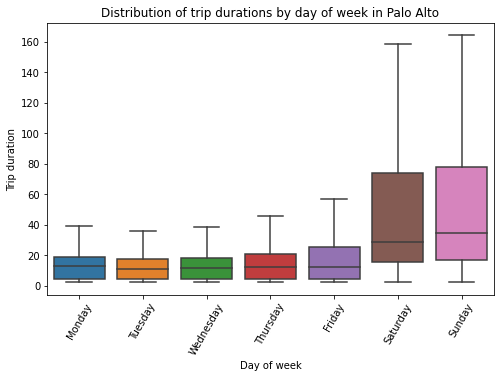

In [ ]:
#bike share trip duration by week
#reorder the days of the week for better visualization
trip_station_df_week = palo_alto_train[["day_of_week", "duration"]].sort_values(by = "day_of_week")

ordered_days = ['Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

trip_station_df_week['day_of_week'] = pd.Categorical(trip_station_df_week['day_of_week'], categories = ordered_days, ordered=True)

#boxplot for each day of the week
plt.figure(figsize=(8,5))
sns.boxplot(x = "day_of_week", y = "duration", data = trip_station_df_week, showfliers = False)
plt.xlabel("Day of week")
plt.ylabel("Trip duration")
plt.xticks(rotation=60)
plt.title("Distribution of trip durations by day of week in Palo Alto")

In the figure above, we see significantly longer average trip durations for weekdays, as well as a more spread out distribution of trip durations. We see a slight uptick in average trip duration for Thursday and Friday, which may indicate some leisure trips happening later in the week.

Text(0.5, 1.0, 'Distribution of trip durations by time of day in Palo Alto')

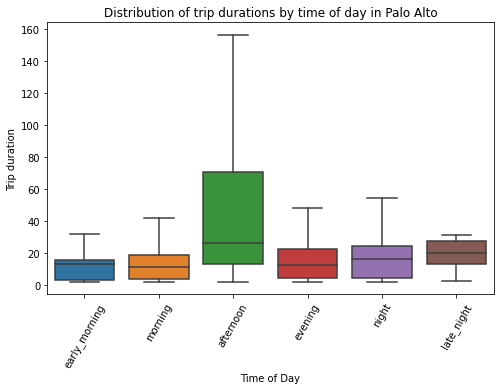

In [ ]:
#bike share trip duration by week
#reorder the days of the week for better visualization
trip_station_df_time = palo_alto_train[["time_of_day", "duration"]].sort_values(by = "time_of_day")

ordered_times = ['early_morning',
 'morning',
 'afternoon',
 'evening',
 'night',
 'late_night']

trip_station_df_time['time_of_day'] = pd.Categorical(trip_station_df_time['time_of_day'], categories = ordered_times, ordered=True)

#boxplot for each day of the week
plt.figure(figsize=(8,5))
sns.boxplot(x = "time_of_day", y = "duration", data = trip_station_df_time, showfliers = False)
plt.xlabel("Time of Day")
plt.ylabel("Trip duration")
plt.xticks(rotation=60)
plt.title("Distribution of trip durations by time of day in Palo Alto")

The figure above shows the boxplots of trip duration corresponding to the different time periods during the day in Palo Alto. We see that early morning, morning, evening, night, and late night trips have similar distributions in trip duration, while afternoon trips show the highest average trip duration as well as the most spread in its distribution. This may be because the weather is the most favorable during the afternoon hours, and travelers may be taking advantage of the weather by taking longer trips.

From our EDA, it is evident that the city of Palo Alto shows some variation in trip duration when observing its relation to a variety of the features in our training datasets. Based on this EDA, we can develop a model for classification of durations as long or short for the Palo Alto data (**palo_alto_train** and **palo_alto_test**) prior to generalizing and extending the model for other cities.

## Generating Labels For Classification

To prepare the data for classification, we need to label the data to train our classifier on it. As previously mentioned, we have chosen the labels of 'short' and 'long' to classify the duration of a trip as one of the two.

Before we can generate the training labels, we first determine a threshold to separate duration into 'short' and 'long' based on the *duration* column in the training data. Duration values above the threshold will be labled as 'long' trips, while trips less than or equal to the threshold will be labeled as 'short' trips.

We determined the threshold for *duration* by its **median** for Palo Alto. The median is more robust to outliers and skewness in the data compared to the mean and ensure class balance.

**Note:** Due to the random nature of the train-test split, the mean and median value will most likely change slightly each time. Thus, the threshold may be different and the labels may be generated differently each time. While this is unfavorable, we choose the median for its robust nature and that the difference in its value will only be minimal each time, therefore minimizing changes in threshold and labels.

In [ ]:
#calculate the median for the training data
pa_med = palo_alto_train['duration'].median()

#make copies of the training and testing data
pa_train = palo_alto_train.copy()
pa_test = palo_alto_test.copy()

#training data: 0 represents a short trip and 1 represents a long trip
pa_train['bin_dur'] = pa_train['duration'].apply(lambda x: 0 if x <= pa_med else 1)

#testing data: 0 represents a short trip and 1 represents a long trip
pa_test = palo_alto_test.copy()
pa_test['bin_dur'] = pa_test['duration'].apply(lambda x: 0 if x <= pa_med else 1)

We also consider the case where we classify trips as either 'short, 'long', or 'intermediate'. To determine these thresholds, we use terciles for *duration* to also ensure class balance. We will implement the multiple class logistic regression model in a future section below.

In [ ]:
#for multiclass regression
quantile1 = pa_train['duration'].quantile(1/3)
quantile2 = pa_train['duration'].quantile(2/3)

# #3 quartiles - short, intermdiate, long trips
def quantiles_duration(x):
   if x < quantile1:
     return 0

   elif x < quantile2:
     return 1

   else:
     return 2

pa_train['bin_dur_mc'] = pa_train['duration'].apply(lambda x: quantiles_duration(x))
pa_test['bin_dur_mc'] = pa_test['duration'].apply(lambda x: quantiles_duration(x))

We see that there is not much class imbalance in the data since we are using the median to threshold the data. If there were class imbalances, then we likely would not be able to fix them through undersampling or oversampling, since our Palo Alto dataset is not sufficiently large.

In [ ]:
print('# of Short Trips in Training Data', pa_train[pa_train['bin_dur']==0].shape[0])
print('# of Long Trips in Training Data', pa_train[pa_train['bin_dur']==1].shape[0])

# of Short Trips in Training Data 2378
# of Long Trips in Training Data 2376


Since we created the 'short' vs 'long' trip variable in the test dataset according to the median of trip duration in the train set, we see that the test data set is pretty balanced. We can thus proceed with additional feature engineering and encoding before implementing our models.

In [ ]:
print('# of Short Trips in Testing Data', pa_test[pa_test['bin_dur']==0].shape[0])
print('# of Long Trips in Testing Data', pa_test[pa_test['bin_dur']==1].shape[0])

# of Short Trips in Testing Data 633
# of Long Trips in Testing Data 572


## Additional Feature Engineering

### Feature Selection

Based on the correlation heatmap in the Additional EDA section, we observe high correlation among weather features with min/mean/max. Intuitively, we will remove these columns entirely to reduce the dimensionality of our dataset.

We use a smaller correlation matrix heatmap to observe correlations between the remaining weather features. It appears there is high correlation between *mean_dew_point_f* and *mean_temperature_f* and between *mean_dew_point_f* and *mean_humidity_f*. We will remove *mean_dew_point_f* to avoid multicollinearity.

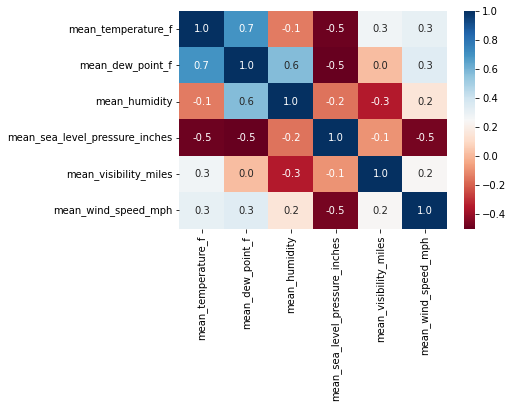

In [ ]:
# heat map for numerical data
correlations = pa_train[['mean_temperature_f',	'mean_dew_point_f',	'mean_humidity',	'mean_sea_level_pressure_inches',	'mean_visibility_miles',	'mean_wind_speed_mph']].corr()
sns.heatmap(correlations, cmap="RdBu", annot=True, fmt=".1f")

We examine the remaining weather features for our feature selection and engineering process. We want to see if there is any significant changes/variation in these features using quick descriptive statistics.

In [ ]:
pa_train['mean_temperature_f'].describe()

count    4754.000000
mean       61.520614
std         5.929640
min        41.000000
25%        57.000000
50%        62.000000
75%        66.000000
max        77.000000
Name: mean_temperature_f, dtype: float64

In [ ]:
pa_train['mean_sea_level_pressure_inches'].describe()

count    4754.000000
mean       30.009983
std         0.122377
min        29.430000
25%        29.920000
50%        29.990000
75%        30.080000
max        30.400000
Name: mean_sea_level_pressure_inches, dtype: float64

In [ ]:
pa_train['mean_humidity'].describe()

count    4754.000000
mean       67.808162
std         9.695241
min        26.000000
25%        64.000000
50%        69.000000
75%        73.000000
max        93.000000
Name: mean_humidity, dtype: float64

In [ ]:
pa_train['mean_visibility_miles'].describe()

count    4754.000000
mean        9.647034
std         0.895993
min         4.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: mean_visibility_miles, dtype: float64

In [ ]:
pa_train['mean_wind_speed_mph'].describe()

count    4754.000000
mean        8.435002
std         3.511528
min         0.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        22.000000
Name: mean_wind_speed_mph, dtype: float64

In [ ]:
pa_train['wind_dir_degrees'].describe()

count    4754.000000
mean      260.767985
std        62.099784
min         2.000000
25%       257.000000
50%       276.000000
75%       294.000000
max       357.000000
Name: wind_dir_degrees, dtype: float64

There appears to be not that much variation in the data from the descriptive statistics for the columns: *mean_sea_level_pressure_inches* and *mean_visibility_miles*. We will remove this features.

### Binning Weather Data

We decided to bin weather data when appropriate, because continuous variables may contain too many unique values to model effectively. We examine the results of these binnings through further EDA.

The feature *events* is not continuous, but we would group it into two bins 'Normal' and 'Bad', because there is relatively fewer data entries for the smaller categories. We see there is a noticeable difference in average duration between the two bins.

In [ ]:
# group the weather into 2 categories: normal and rain/fog/thunderstorm
pa_train['events'] = pa_train['events'].apply(lambda x: "Bad" if (x == 'Fog') |
                          (x == 'Rain') | (x == 'Fog-rain') | (x == 'Rain-thunderstorm') else x)

pa_test['events'] = pa_test['events'].apply(lambda x: "Bad" if (x == 'Fog') |
                          (x == 'Rain') | (x == 'Fog-rain') | (x == 'Rain-thunderstorm') else x)

In [ ]:
#group by events and calculate average duration
pa_events = pa_train.groupby('events')['duration'].mean().reset_index()
pa_events

,events,duration
0,Bad,29.408817
1,Normal,37.618382


The feature *mean_temperature_f* is grouped into two bins 'low' if the value is less than 60 and 'high' if the value is greater or equal to 60. This threshold value was determined through rounding the descriptive statistic mean and hardcoding the value. The new feature is called *temperature*. We see there is a noticeable difference in average duration between the two bins.

**Note:** The *mean_temperature_f* feature will be removed.

In [ ]:
#encode low and high temperature values
pa_train['temperature'] = pa_train['mean_temperature_f'].apply(lambda x: "low" if (x < 60) else "high")

pa_test['temperature'] = pa_test['mean_temperature_f'].apply(lambda x: "low" if (x < 60) else "high")

In [ ]:
#group by temperature and calculate average duration
pa_temp = pa_train.groupby('temperature')['duration'].mean().reset_index()
pa_temp

,temperature,duration
0,high,38.337140
1,low,32.730388


The feature *mean_humidity* is grouped into two bins 'low' if the value is less than 70 and 'high' if the value is greater or equal to 70. This threshold value was determined through rounding the descriptive statistic mean and hardcoding the value. The new feature is called *rel_humidity*. We see there is a smaller difference in average duration between the two bins.

**Note:** The *mean_humidity* feature will be removed.

In [ ]:
#encode low and high humidity values
pa_train['rel_humidity'] = pa_train['mean_humidity'].apply(lambda x: "low" if (x < 70) else "high")

pa_test['rel_humidity'] = pa_test['mean_humidity'].apply(lambda x: "low" if (x < 70) else "high")

In [ ]:
#group by humidity and calculate average duration
pa_hum = pa_train.groupby('rel_humidity')['duration'].mean().reset_index()
pa_hum

,rel_humidity,duration
0,high,35.105446
1,low,37.247134


The feature *mean_wind_speed_mph* is grouped into two bins 'low' if the value is less than 9 and 'high' if the value is greater or equal to 9. This threshold value was determined through the descriptive statistic mean and hardcoding the value. The new feature is called *wind*. We see there is no noticebable difference in average duration between the two bins.

**Note:** The *mean_wind_speed_mph* and *wind* features will be removed.

In [ ]:
#encode low and high wind speed values
pa_train['wind'] = pa_train['mean_wind_speed_mph'].apply(lambda x: "low" if (x < 9) else "high")

pa_test['wind'] = pa_test['mean_wind_speed_mph'].apply(lambda x: "low" if (x < 9) else "high")

In [ ]:
#group by wind and calculate average duration
pa_wind = pa_train.groupby('wind')['duration'].mean().reset_index()
pa_wind

,wind,duration
0,high,36.368979
1,low,36.063284


We remove weather features mentioned earlier as well as additional feature we consider not in the scope of our problem.

In [ ]:
#drop columns in the training data
pa_train = pa_train.drop(['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
                          'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
                          'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
                          'min_sea_level_pressure_inches', 'max_visibility_miles',
                          'mean_visibility_miles', 'min_visibility_miles', 'max_wind_speed_mph',
                          'mean_wind_speed_mph','max_gust_speed_mph', 'precipitation_inches',
                          'cloud_cover', 'wind_dir_degrees', 'wind'
                          ], axis =1 )

In [ ]:
#drop columns in the testing data
pa_test = pa_test.drop(['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
                          'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
                          'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
                          'min_sea_level_pressure_inches', 'max_visibility_miles',
                          'mean_visibility_miles', 'min_visibility_miles', 'max_wind_speed_mph',
                          'mean_wind_speed_mph','max_gust_speed_mph', 'precipitation_inches',
                          'cloud_cover', 'wind_dir_degrees', 'wind'
                          ], axis =1 )

### Binning Weekday/Weekend

Similar to what we did in our regression problem, we want to group the days of the week into 'weekday' and 'weekend', because there appears to be higher average duration for Saturday and Sunday compared to ther days, based on the EDA plot.

In [ ]:
#create weekend/weekday binary feature
pa_train['weekday_or_weekend'] = pa_train['day_of_week'].apply(lambda x: "weekend" if (x == 'Saturday') | (x == 'Sunday') else 'weekday')

pa_test['weekday_or_weekend'] = pa_test['day_of_week'].apply(lambda x: "weekend" if (x == 'Saturday') | (x == 'Sunday') else 'weekday')

In [ ]:
#group by weekend/weekday and calculate average duration
pa_ww = pa_train.groupby('weekday_or_weekend')['duration'].mean().reset_index()
pa_ww

,weekday_or_weekend,duration
0,weekday,29.466644
1,weekend,57.833981


In [ ]:
#remove 'day_of_week'
pa_train = pa_train.drop(['day_of_week'], axis = 1)
pa_test = pa_test.drop(['day_of_week'], axis = 1)

Now that we have an intuition of what features are correlated with duration and may explain the variation in the duration of a trip, we want to remove unused features and include only the ones that will model bike share trip duration well.

In [ ]:
#subset features for training data
pa_train = pa_train[['start_station_name',
 'subscription_type',
 'events',
 'month',
 'time_of_day',
 'bin_dur',
 'bin_dur_mc',
 'temperature',
 'rel_humidity',
 'weekday_or_weekend']]

In [ ]:
#subset features for testing data
pa_test = pa_test[['start_station_name',
 'subscription_type',
 'events',
 'month',
 'time_of_day',
 'bin_dur',
 'bin_dur_mc',
 'temperature',
 'rel_humidity',
 'weekday_or_weekend']]

### One Hot Encoding

We want to encode our categorical features of interest so that they can be assigned weights in our models and help in the classification of bike share trips as either short or long, or in the multiclass case, as short, long, or intermediate. We will use the same function for one-hot encoding designed in the linear regression section, since we are performing the same operation. The code is reproduced below for ease of referral.

In [ ]:
'''
This function one-hot encodes the categorical variables of interest for the training
and testing dataframes in-place. It requires the training, testing, and variable name
as arguments.
'''

def one_hot_encode(train_df, test_df, category):
  encoder = OneHotEncoder()
  encoded_columns = encoder.fit_transform(train_df[[category]]).toarray()
  new_columns = encoder.categories_[0]
  train_df[new_columns] = encoded_columns

  encoder_test = OneHotEncoder()
  cols_test = encoder_test.fit_transform(test_df[[category]]).toarray()
  test_cols = encoder_test.categories_[0]
  test_df[test_cols] = cols_test

In [ ]:
#one hot encode the features for both the training and testing sets
one_hot_encode(pa_train, pa_test,'start_station_name')
one_hot_encode(pa_train, pa_test,'subscription_type')
one_hot_encode(pa_train, pa_test,'events')
one_hot_encode(pa_train, pa_test,'month')
one_hot_encode(pa_train, pa_test,'time_of_day')
one_hot_encode(pa_train, pa_test,'temperature')
one_hot_encode(pa_train, pa_test,'rel_humidity')
one_hot_encode(pa_train, pa_test,'weekday_or_weekend')

In [ ]:
#drop columns we don't need after one hot encoding
pa_train = pa_train.drop(['start_station_name', 'subscription_type', 'events', 'month', 'time_of_day', 'temperature', 'rel_humidity', 'weekday_or_weekend'], axis=1)
pa_test = pa_test.drop(['start_station_name', 'subscription_type', 'events', 'month', 'time_of_day', 'temperature', 'rel_humidity', 'weekday_or_weekend'], axis=1)

In [ ]:
#split into x and y training and testing
x_train = pa_train.drop(['bin_dur', 'bin_dur_mc'], axis=1)
y_train = pa_train['bin_dur']

x_test = pa_test.drop(['bin_dur', 'bin_dur_mc'], axis=1)
y_test = pa_test['bin_dur']

## Models

We explore five potential models in this section. The first four relate to binary classification, including logistic regression, support vector machines, random forest classifiers, and neural networks. We also consider a multiclass logistic regression for predicting our three classes. The predictors we are using for these models are: start station name, subscription type, weather events, month, time of day, temperature, relative humidity, and whether the trip was on a weekday or weekend.

### Binary Logistic Regression

We first implement a binary logistic regresion model to classify bike share trips as either short vs. long trips in Palo Alto. We evaluate the model performance based on the accuracy score first, as well as the confusion matrix, ROC curve, and the F1 score. We use a set of metrics to evaluate our model since we know that accuracy score is not a good measure of accuracy, as it weighs misclassifications (false negatives, false positives) equally. Thus looking at the confusion matrix as well as the ROC curve and the F1 score can give us a better understanding of the model performance.

In [ ]:
#logistic regression fit and predict
clf = LogisticRegression().fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
#model accuracy
log_acc = accuracy_score(y_test, y_pred)
print("The accuracy score for binary logistic regresion is " +
      str(round(log_acc, 2) * 100) + "%")

The accuracy score for binary logistic regresion is 81.0%


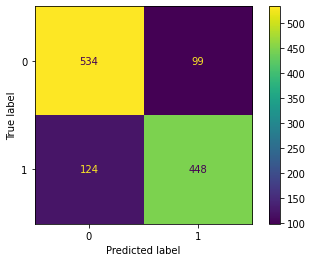

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  534
False Positive:  99
False Negative:  124
True Positive:  448


ROC Area Under the Curve:  0.8134093394756903


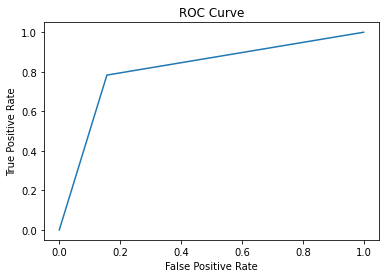

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8007149240393208


From this model, we are able to achieve around 81% accuracy as well as a large F1 score. Recall that the F1 score balances both precision and recall, thus conveying how the model can capture positive cases (recall) and be accurate with its positive cases (precision). The large F1 score indicate that the model is robust due to a lack of class imbalance.

#### Hyperparameter Tuning

To see if we can improve the model performance for the binary logistic regression model, we perform some hyperparameter tuning using grid search and k-fold cross validation.

In [ ]:
clf = LogisticRegression()
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#grid search to tune the hyperparameters
# Source [10]
clf = LogisticRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'fit_intercept':[True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}
search = GridSearchCV(clf, param, n_jobs=-1, cv=cv)
result = search.fit(x_train, y_train)
y_pred = search.predict(x_test)

In [ ]:
#model accuracy
log_acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_acc)

Accuracy:  0.8157676348547718


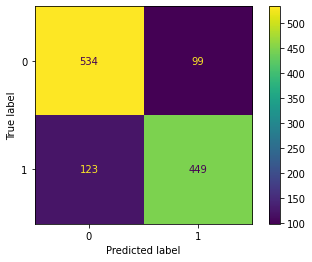

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=search.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  534
False Positive:  99
False Negative:  123
True Positive:  449


ROC Area Under the Curve:  0.8142834653498161


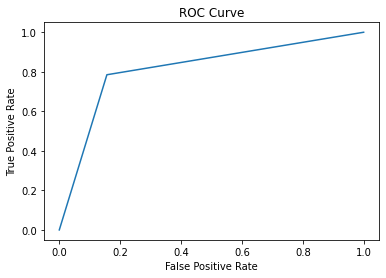

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8017857142857143


Here, we see that the F1 scores and ROC are high and remain relatively the same after hyperparameter tuning, with some slight improvements. This means that precision and recall are large, so binary logistic regression could potentially be a final model.

### Support Vector Machines (SVM)

We want to see if a support vector machine (SVM) could be a better model compared to binary logistic regression. Recall that an SVM classifies data by finding the hyperplane that separates the data points between the two classes.


In [ ]:
#SVM fit and predict
clf = svm.SVC().fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
#model accuracy
svm_acc = accuracy_score(y_test, y_pred)
print("The accuracy score for SVM is " +
      str(round(svm_acc, 2) * 100) + "%")

The accuracy score for SVM is 81.0%


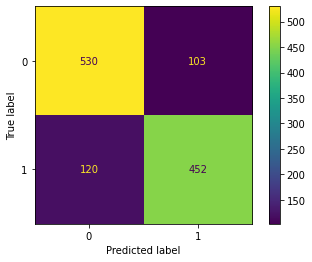

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  530
False Positive:  103
False Negative:  120
True Positive:  452


ROC Area Under the Curve:  0.8137462853102664


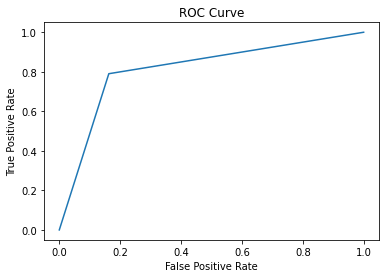

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8021295474711624


Using the default parameters of the SVM, we are able to achieve a similar accuracy and confusion matrix statistics as the binary logistic regression. The F1 scores are large, thus indicating the model is robust due to a lack of class imbalance.

#### Hyperparameter Tuning

To see if we can improve the model performance for the SVM, we perform some hyperparameter tuning.

In [ ]:
clf = svm.SVC()
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
#grid search to tune the hyperparameters
# Source [10]
clf = svm.SVC()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'max_iter':[100, 200, 300, 400, 500, -1]
}
search = GridSearchCV(clf, param, n_jobs=-1, cv=cv)
result = search.fit(x_train, y_train)
y_pred = search.predict(x_test)

In [ ]:
# accuracy score
acc = accuracy_score(y_test, y_pred)
print("The accuracy score for SVM is " +
      str(round(acc, 2) * 100) + "%")

The accuracy score for SVM is 81.0%


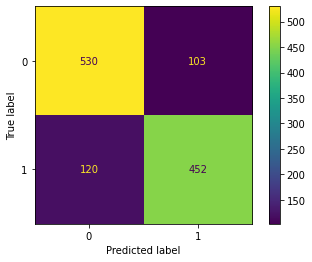

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=search.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  530
False Positive:  103
False Negative:  120
True Positive:  452


ROC Area Under the Curve:  0.8137462853102664


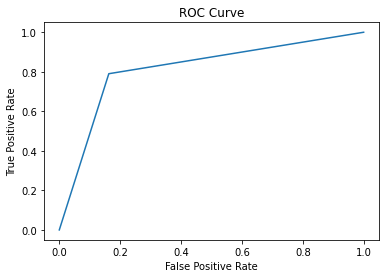

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.8021295474711624


After tuning the hyperparameters in the SVM, we see similar model performance with the same amount of misclassifications and same F1 score. Between the two models, we see that the F1 scores and ROC are high, meaning that precision and recall are large, so may seem like a potential final model.

### Random Forest Classifier

To see if we can improve our models, we try a random forest classifier and also tune the hyperparameters accordingly.

In [ ]:
# random forest classifier fit and predict
clf = RandomForestClassifier().fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
#model accuracy
rf_acc = accuracy_score(y_test, y_pred)
print("The accuracy score for the random forests classifer is " +
      str(round(rf_acc, 2) * 100) + "%")

The accuracy score for the random forests classifer is 80.0%


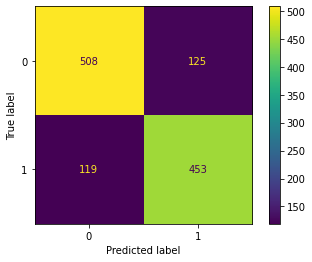

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  508
False Positive:  125
False Negative:  119
True Positive:  453


ROC Area Under the Curve:  0.797242844043792


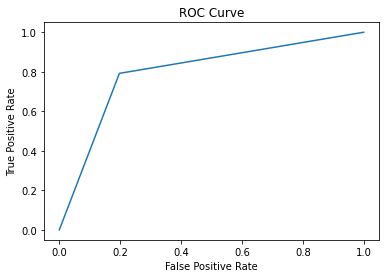

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7878260869565218


Compared to the binary logistic regression model and SVM, we achieve slightly lower accuracy and lower F1 scores, with more misclassifications based on the confusion matrix. The F1 scores indicate the model is robust due to a lack of class imbalance. In the next section, we further tune the hyperparameters to see if we can improve this model performance.

#### Hyperparameter Tuning

In [ ]:
clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#grid search to tune the hyperparameters
# # Source [10]
clf = RandomForestClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'bootstrap': [True, False],
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 2, 3, 4],
    'criterion' :['gini', 'entropy']
}

search = GridSearchCV(clf, param, n_jobs=-1, cv=cv)
result = search.fit(x_train, y_train)
y_pred = search.predict(x_test)

In [ ]:
 # accuracy score
acc = accuracy_score(y_test, y_pred)
print("The accuracy score for the random forests classifer is " +
      str(round(acc, 2) * 100) + "%")

The accuracy score for the random forests classifer is 80.0%


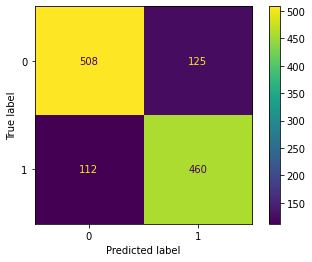

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=search.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  508
False Positive:  125
False Negative:  112
True Positive:  460


ROC Area Under the Curve:  0.803361725162673


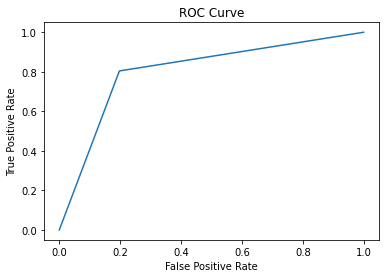

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7951598962834918


The scores are relatively the same following hyperparameter tuning, with some slight improvement from the original model (as evidenced by the F1 score). This final model compares well to the model performance from the binary logistic regression and SVM, however has a slightly lower testing accuracy.

### Neural Networks

We also implement a neural network to see if this model structure can better predict our two classes.

In [ ]:
#neural network fit and predict
# originally was at 300, set to 2000 to avoid convergence issues
clf = MLPClassifier(max_iter=2000).fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
#model accuracy
mlp_acc = accuracy_score(y_test, y_pred)
print("The accuracy score for the neural network is " +
      str(round(mlp_acc, 2) * 100) + "%")

The accuracy score for the neural network is 80.0%


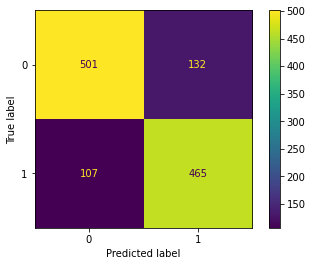

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [ ]:
#false positives / negatives and true positives / negatives
tn, fp, fn, tp = cm.ravel()
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print('True Positive: ', tp)

True Negative:  501
False Positive:  132
False Negative:  107
True Positive:  465


ROC Area Under the Curve:  0.8022031286249296


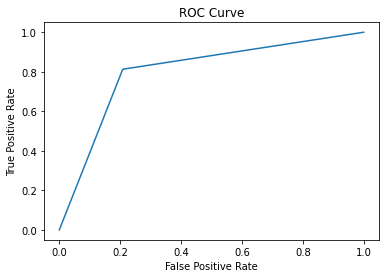

In [ ]:
# ROC curve
print('ROC Area Under the Curve: ', metrics.roc_auc_score(y_test, y_pred))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='binary'))

F1 Score:  0.7955517536355861


Here, we see that the F1 scores and ROC are decently high without hyperparameter tuning, meaning that precision and recall are sufficiently large, so this seems like a good model. In the neural network, we see the most false positives (i.e., we predict a long trip but the trip is actually short). We have an intuition; however, that our data are not suitable for neural networks due to to the lack of many numerical features and the fact that our dataset isn't sufficiently large for a neural net to perform classification well.

### Multiclass Classification

The previous models had a target label of short vs. long trips, and now we want to make our target labels be multiple classes, that is: short, intermediate, and long trips. We use a multiple class logistic regression model to fit to our training data and then predict on our testing data.

In [ ]:
#split into x and y training and testing
x_train = pa_train.drop(['bin_dur', 'bin_dur_mc'], axis=1)
y_train = pa_train['bin_dur_mc']

x_test = pa_test.drop(['bin_dur', 'bin_dur_mc'], axis=1)
y_test = pa_test['bin_dur_mc']

In [ ]:
#multiclass logistic regression fit and predict
multi_log_reg = LogisticRegression(solver='lbfgs', multi_class='auto').fit(x_train, y_train)
y_pred = multi_log_reg.predict(x_test)

In [ ]:
#accuracy score
print("The accuracy score for multiclass logistic regresion is " +
      str(round(accuracy_score(y_test, y_pred), 2) * 100) + "%")

The accuracy score for multiclass logistic regresion is 67.0%


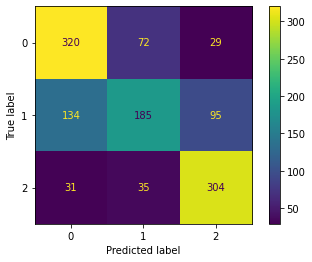

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=multi_log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=multi_log_reg.classes_)
disp.plot()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='weighted'))

F1 Score:  0.6608039368626827


The multiclass logistic regression model to predict short, intermediate, and long trips in Palo Alto has a prediction accuracy of 67%. Based on the confusion matrix, we see that there a lot of incorrect predictions when the true label was 1, or an intermediate trip. We were able to predict either short or long trips with higher accuracy (more true positives). The F1 score is also lower, which indicates both poor precision and recall. <br>

Based on these results, we may want to stick with just the short vs. long trips as opposed to creating additional classes. This may likely be due to do some external features or variables needed in order to explain intermediate trips. Additionally, we could try adjusting the threshold of determining the classes (recall we used terciles) or performing hyperparameter tuning to increase the model performance, which we will do in the next section.

####Hyperparameter Tuning

In [ ]:
#grid search to tune the hyperparameters
# Source [10]
multi_log_reg = LogisticRegression(multi_class='auto')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
param = {
    'fit_intercept':[True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}
search = GridSearchCV(multi_log_reg, param, n_jobs=-1, cv=cv)
result = search.fit(x_train, y_train)
y_pred = search.predict(x_test)

In [ ]:
#accuracy score
print("The accuracy score for multiclass logistic regresion is " +
      str(round(accuracy_score(y_test, y_pred), 2) * 100) + "%")

The accuracy score for multiclass logistic regresion is 67.0%


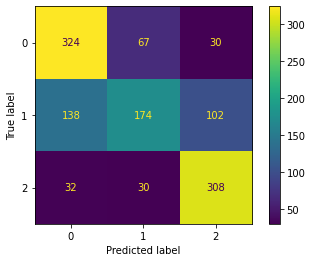

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=search.classes_)
disp.plot()

In [ ]:
print('F1 Score: ', metrics.f1_score(y_test, y_pred, average='weighted'))

F1 Score:  0.655483504823863


With additional hyperparameter tuning, we end up with similar results as the default parameters, which indicates that the multiclass logistic regression model may not be well-suited to this data. We end our classification models with a discussion of the most favorable model.

## Selection of Final Model

To classify bike share trips as either short or long in Palo Alto, we implemented binary classification models (logistic regression, support vector machines, random forest classifier, and neural network) as well as multi-class classifiers (to additionally classify trips as short, long, or intermediate). Comparing first the multi-class against the binary class models, we were not able to predict the 'intermediate' trip duration class with high accuracy, as evidence by the misclassifications in the confusion matrix for the multiclass model. This indicates that, based on these models, we want to propose a short vs. long trip binary classification model.<br>

Out of the four models (logistic regression, support vector machines, random forest classifier, and neural network), we saw the strongest model performance from binary logistic regression, the support vector machine, and random forest classifier with regards to the metrics of model accuracy and F1 scores. The neural network model however did not perform well, most likely due to our small data set. However, to reduce computation time in training the model and tuning the hyperparameters, we may prefer a binary logistic regression model rather than a support vector machine or random forest classifier.

# Conclusion

## EDA

Our exploratory data analysis was able to uncover some key trends in our data among bike share trips, stations, and other weather and time related features.

First, from our plots comparing the distributions of trip durations between customers and subscribers, we found that trips taken by subscribers were taken at low intensity (shorter duration), while customers took much more intense trips (longer trip duration), which may indicate more leisure trips. This provides some insight into the fact that short trips may correspond to work commutes, while long trips may correspond to leisure travel. <br>

From the k-means clustering results, we were able to find several groupings of stations that exhibit similar trends in total trip counts and average trip duration per station. Most notably, we found that the University and Emerson station in Palo Alto has the most intense usage (highest average trip duration) so further enhancements can be directed towards accomodating this trip intensity.

We were able to further explore this station and the trips in Palo Alto in our classification model. From our EDA, we also found the largest variation in weather events and time of day by trip duration for the city of Palo Alto, which was a good candidate to narrow our scope down for the classification models. <br>

##Regression

As discussed in our Analysis of Models section under Regression, our regression models to predict bike share trip duration were underperforming. Despite conducting a variety of regression models, hyperparameter tuning to improve the model performance, and additional feature engineering, we attributed our underperforming models due to our models underfitting our data. One major challenge that we faced in training a regression model was the fact that we were using categorical features to predict a continuous variable, bike share trip duration. To deal with this issue, we had to do to 2 major things: 1) implement classification models and 2) focus on one specific city to implement our model with additional feature engineering for the specific location. We discussed this process in more detail in the Analysis of Models section under Regression.

##Classification

In our classification models, we wanted to predict whether a bike share trip would be classified as short vs. long, or in the multiclass class, short vs. long vs. intermediate in Palo Alto. We considered several types of models including binary logistic regression, support vector machines, random forest classifiers, neural networks, and multiclass logistic regression. We found that binary logistic regression and support vector machines were best suited to predict short vs. long trips with around an 81% accuracy and high F1 scores. Some of the challenges associated with our classification problem was that we had to determine the threshold based on our own understanding of the data, as trip duration was a continuous value. Additionally, we did not find any significant correlations between trip duration and the numerical feature data, so we only had categorical features. In the end, our model was able to predict whether trips can be classified as short vs. long in Palo Alto with a resonable degree of accuracy (81%) and good model robustness, as evidenced by the high F1 scores. With this information, we can inform Bay Wheels on potential characteristics that would impact trip intensity, thus providing them with the knowledge to expand their system and services using targeted enhancements within the Palo Alto area.

#Future Work

In our future work, there are several things we would plan to do to further address some of the limitations in our work.

*   **Gather additional feature data**: In the data set provided, we were provided with trip characteristics, weather, and station-level features. While these certainly provide an array of features to select from, we want to further pursue other options, including gathering individual-level data and variables as discussed in the Analysis of Models section under Regression. This could entail potential traveler characteristics, trip activity type (leisure vs. work), as well as origin-destination characteristics about each trip. Using these features, we could run additional models that could allow us to predict certain types of trips based on station, weather, individual, and trip-level characteristics.

* **Implement the model for multiple cities**: While the classification model predicts short vs. long trip durations in Palo Alto only, we note that this model and pipeline can be generalized to any city in our data set. In future work, we would want to implement this model for more cities and increase the model's usefulness.

*   **Perform threshold tuning**: In generating the labels for the binary and multiclass classification, we used the median of our bike share trip durations to create the cutoff, as well as terciles to create cutoffs for the multiclass models. While the median seemed to perform okay, the multiclass model could benefit from additional threshold tuning. For the multiclass model, we could explore adding more categories of trips (for example, short, short-medium, medium-long, long) to further classify trip durations. While there is not a standard method to establish a treshold, we took the appropriate considerations to ensure class imbalance and model robustness.

*   **More complex machine learning methods**: As we suffered from underfitting, especially in the linear regression case, we could potentially consider more complex models such as feed-forward neural networks or boosting methods to improve model complexity and address underfitting. However, this may not be guaranteed to provide better results.

# Sources


[1] https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share  (dataset)

[2] https://mtc.ca.gov/operations/traveler-services/bay-wheels-bike-share-program

[3] https://www.lyft.com/bikes/bay-wheels/expansion

[4] https://www.weather.gov/arx/why_dewpoint_vs_humidity

[5] https://graphical.weather.gov/definitions/defineMaxMinRH.html

[6] https://graphical.weather.gov/definitions/defineSfcVisibility.html

[7] https://www.linkedin.com/pulse/how-handle-outliers-piyush-kumar

[8] https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94

[9] https://realpython.com/k-means-clustering-python/

[10] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html